# **Enapsys Energy Demand**

**General description:**

The electricity demand of France is very much dependent on weather data. The demand of France is an important driver of European electricity prices, as it is one of the biggest countries. France has a lot of interconnections with surrounding countries. Hence, in periods of high demand France is likely to import electricity from neighboring countries, which will result in higher prices in France and the other countries. In periods of low demand, France is likely to export, which will result in lower prices. That is the reason that market parties need a good insight and forecast of this demand in France.



**Assignment:**

Please create a demand forecast for France on an hourly level up to 48 hours ahead, for the French Market. For example, if you create a forecast on 11 March at 00:00. You will forecast the demand until March 13th at 00:00.



**Extra analysis:** 

Please indicate, on a monthly basis, what the average demand is for a weekday or a weekend at a certain temperature. We are very interested to see what one degree colder in winter or one degree warmer in summer has, as an effect on demand.


The data for the analysis is contained in the following csv files:



**dataset.csv** - Demand Actual data is the target value, which has to be forecasted. This is the aggregated demand of France on an hourly level. The dataset consists of different features, which possibly can be used. 


**dataset_coords.csv** - This dataset contains weather data on a coordinate level. Although the target (demand) is aggregated over France, the weather can be different over the country.




In [ ]:
!pip install sort-dataframeby-monthorweek
!pip install sorted-months-weekdays

   ***
##**Phase 1: Exploratory Data Analysis**
***
### **Phase 1 Notebook Content:**


***

### **Data overview**

In [ ]:
#import libraries
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import holidays
import sort_dataframeby_monthorweek as sd
from numpy import array

In [ ]:
data = pd.read_csv('dataset.csv')

### **Data overview**

In [ ]:
print('Date Shape')
print(data.shape)

print('\nData preview')
data.head()

Date Shape
(45432, 17)

Data preview


Unnamed: 0  demand [MW]  solar_actual [MW]  \
0  2017-01-01 00:00:00+01:00     76345.25                0.0   
1  2017-01-01 01:00:00+01:00     75437.00                0.0   
2  2017-01-01 02:00:00+01:00     73368.25                0.0   
3  2017-01-01 03:00:00+01:00     72116.00                0.0   
4  2017-01-01 04:00:00+01:00     68593.75                0.0   

   solar_forecast [MW]  solar_inferred_capacity [MW]  wind_actual [MW]  \
0                  NaN                       5756.44            597.50   
1                  NaN                       5756.44            597.50   
2                  NaN                       5756.44            635.25   
3                  NaN                       5756.44            628.50   
4                  NaN                       5756.44            608.50   

   wind_inferred_capacity [MW]  albedo [%]  cloud_cover [%]  \
0                     10513.95         0.0             2.45   
1                     10513.95         0.0             2.48   
2                     10513.95         0.0             4.62   
3                     10513.95         0.0             6.13   
4                     10513.95         0.0             6.75   

   frozen_precipitation [%]  pressure [Pa]  radiation [W/m2]  \
0                     -3.80       102875.0               0.0   
1                     -3.46       102839.0               0.0   
2                     -5.48       102735.0               0.0   
3                     -6.91       102660.0               0.0   
4                     -7.50       102629.0               0.0   

   air_tmp [Kelvin]  ground_tmp [Kelvin]  apparent_tmp [Kelvin]  \
0            271.60               269.82                 269.84   
1            271.62               269.85                 269.79   
2            271.61               269.93                 269.58   
3            271.60               269.99                 269.44   
4            271.60               270.02                 269.38   

   wind_direction [angle]  wind_speed [m/s]  
0                   209.0              2.97  
1                   212.0              3.13  
2                   218.0              3.25  
3                   218.0              3.37  
4                   219.0              3.42

In [ ]:
print('\nData Information')
print(data.info())

print('\nMissing values')
print(data.isnull().sum())


Data Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45432 entries, 0 to 45431
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    45432 non-null  object 
 1   demand [MW]                   45429 non-null  float64
 2   solar_actual [MW]             45413 non-null  float64
 3   solar_forecast [MW]           45210 non-null  float64
 4   solar_inferred_capacity [MW]  45432 non-null  float64
 5   wind_actual [MW]              45413 non-null  float64
 6   wind_inferred_capacity [MW]   45432 non-null  float64
 7   albedo [%]                    45415 non-null  float64
 8   cloud_cover [%]               45416 non-null  float64
 9   frozen_precipitation [%]      45422 non-null  float64
 10  pressure [Pa]                 45421 non-null  float64
 11  radiation [W/m2]              45416 non-null  float64
 12  air_tmp [Kelvin]              45422 non-nu

#### **Data Formatting**

In [ ]:
data.rename(columns={"Unnamed: 0" : 'Date'}, inplace=True)
#convert to UTC time format
data['Date'] = pd.to_datetime(data['Date'], utc=True)   #default

#convert to France's timezone
data['Date'] = data['Date'].apply(lambda x: pd.to_datetime(x).tz_convert('Europe/Paris'))
data['Date'] = data['Date'].dt.strftime('%Y-%m-%d %H:%M:%S')


### **Handling missing values**

In [ ]:
#fill forecast with 0
data['solar_forecast [MW]'] = data['solar_forecast [MW]'].fillna(0)

#creating a separate data for weekly and monthly analysis
data1 = data.copy()

data1['Date'] = pd.to_datetime(data1['Date'], format="%Y-%m-%d %H")

data1 = data1.interpolate(method='bfill')
data1 = data1.interpolate(method='ffill')

In [ ]:
print('Missing values')
data1.isnull().sum()

Missing values


Date                            0
demand [MW]                     0
solar_actual [MW]               0
solar_forecast [MW]             0
solar_inferred_capacity [MW]    0
wind_actual [MW]                0
wind_inferred_capacity [MW]     0
albedo [%]                      0
cloud_cover [%]                 0
frozen_precipitation [%]        0
pressure [Pa]                   0
radiation [W/m2]                0
air_tmp [Kelvin]                0
ground_tmp [Kelvin]             0
apparent_tmp [Kelvin]           0
wind_direction [angle]          0
wind_speed [m/s]                0
dtype: int64

#### **Creating useful variables for analysis**

In [ ]:
data1['hour'] = data1['Date'].dt.hour
data1['day'] = data1['Date'].dt.dayofyear
data1['week'] = data1['Date'].dt.week
data1['month'] = data1['Date'].dt.month_name()
data1['weekday'] = data1['Date'].dt.day_name()

In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45432 entries, 0 to 45431
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          45432 non-null  datetime64[ns]
 1   demand [MW]                   45432 non-null  float64       
 2   solar_actual [MW]             45432 non-null  float64       
 3   solar_forecast [MW]           45432 non-null  float64       
 4   solar_inferred_capacity [MW]  45432 non-null  float64       
 5   wind_actual [MW]              45432 non-null  float64       
 6   wind_inferred_capacity [MW]   45432 non-null  float64       
 7   albedo [%]                    45432 non-null  float64       
 8   cloud_cover [%]               45432 non-null  float64       
 9   frozen_precipitation [%]      45432 non-null  float64       
 10  pressure [Pa]                 45432 non-null  float64       
 11  radiation [W/m2]            

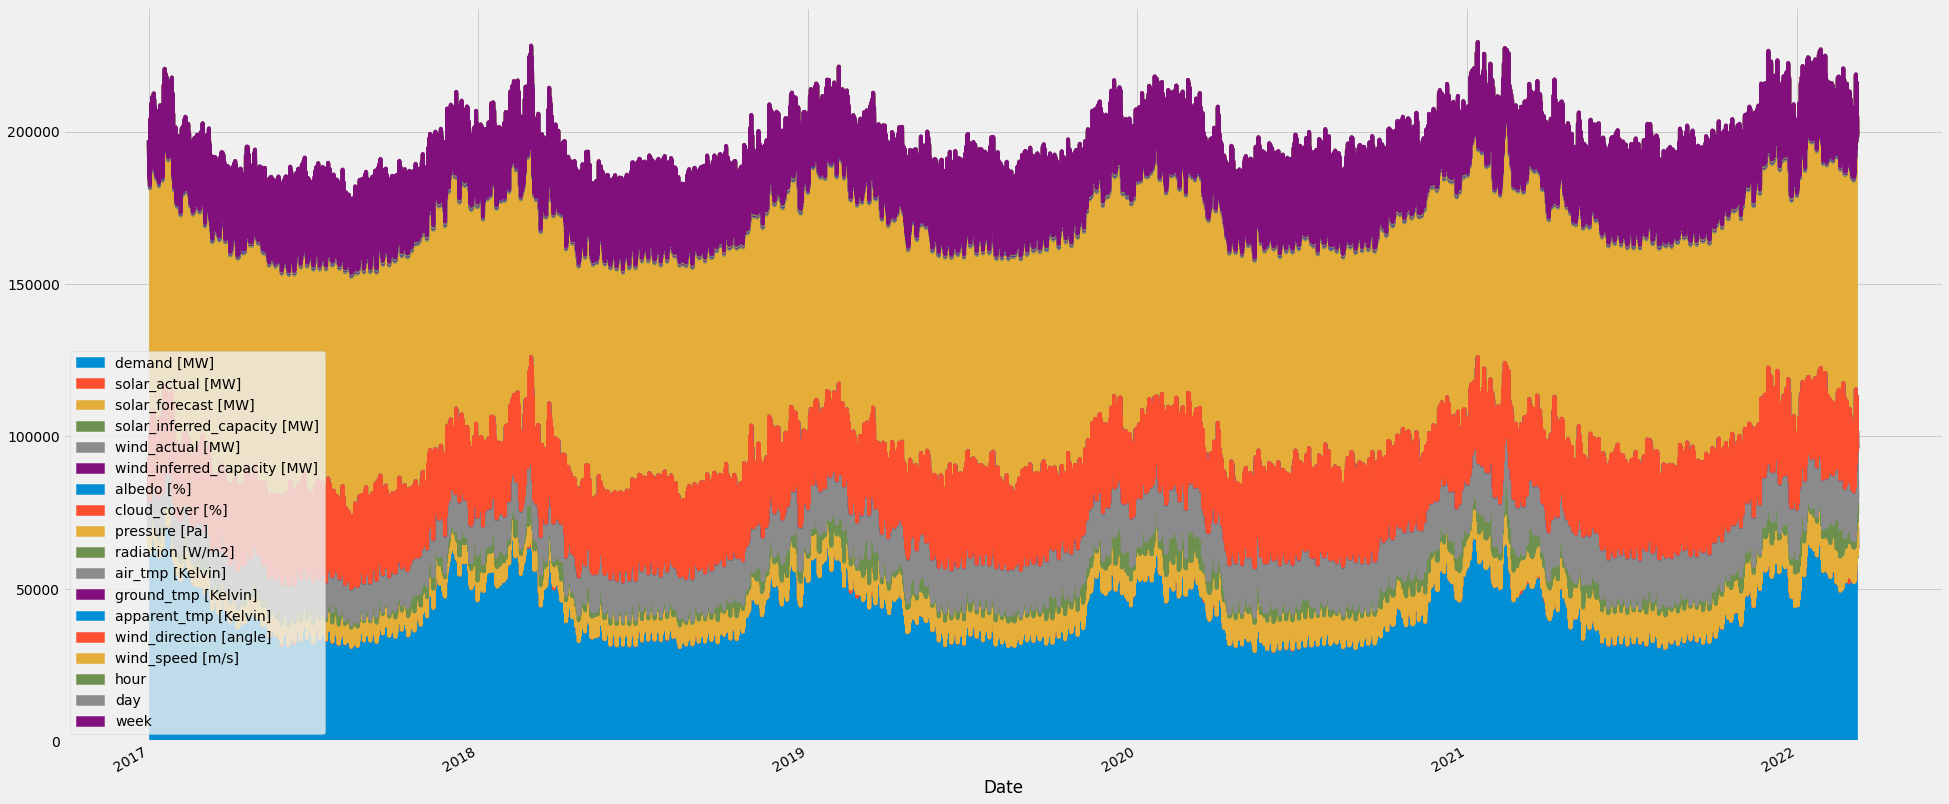

In [ ]:
plt.style.use('fivethirtyeight')
ax = data1.drop('frozen_precipitation [%]', axis=1).set_index('Date').plot.area(
    figsize=(30,15))
plt.show()

In [ ]:
data1.columns

Index(['Date', 'demand [MW]', 'solar_actual [MW]', 'solar_forecast [MW]',
       'solar_inferred_capacity [MW]', 'wind_actual [MW]',
       'wind_inferred_capacity [MW]', 'albedo [%]', 'cloud_cover [%]',
       'frozen_precipitation [%]', 'pressure [Pa]', 'radiation [W/m2]',
       'air_tmp [Kelvin]', 'ground_tmp [Kelvin]', 'apparent_tmp [Kelvin]',
       'wind_direction [angle]', 'wind_speed [m/s]', 'hour', 'day', 'week',
       'month', 'weekday'],
      dtype='object')

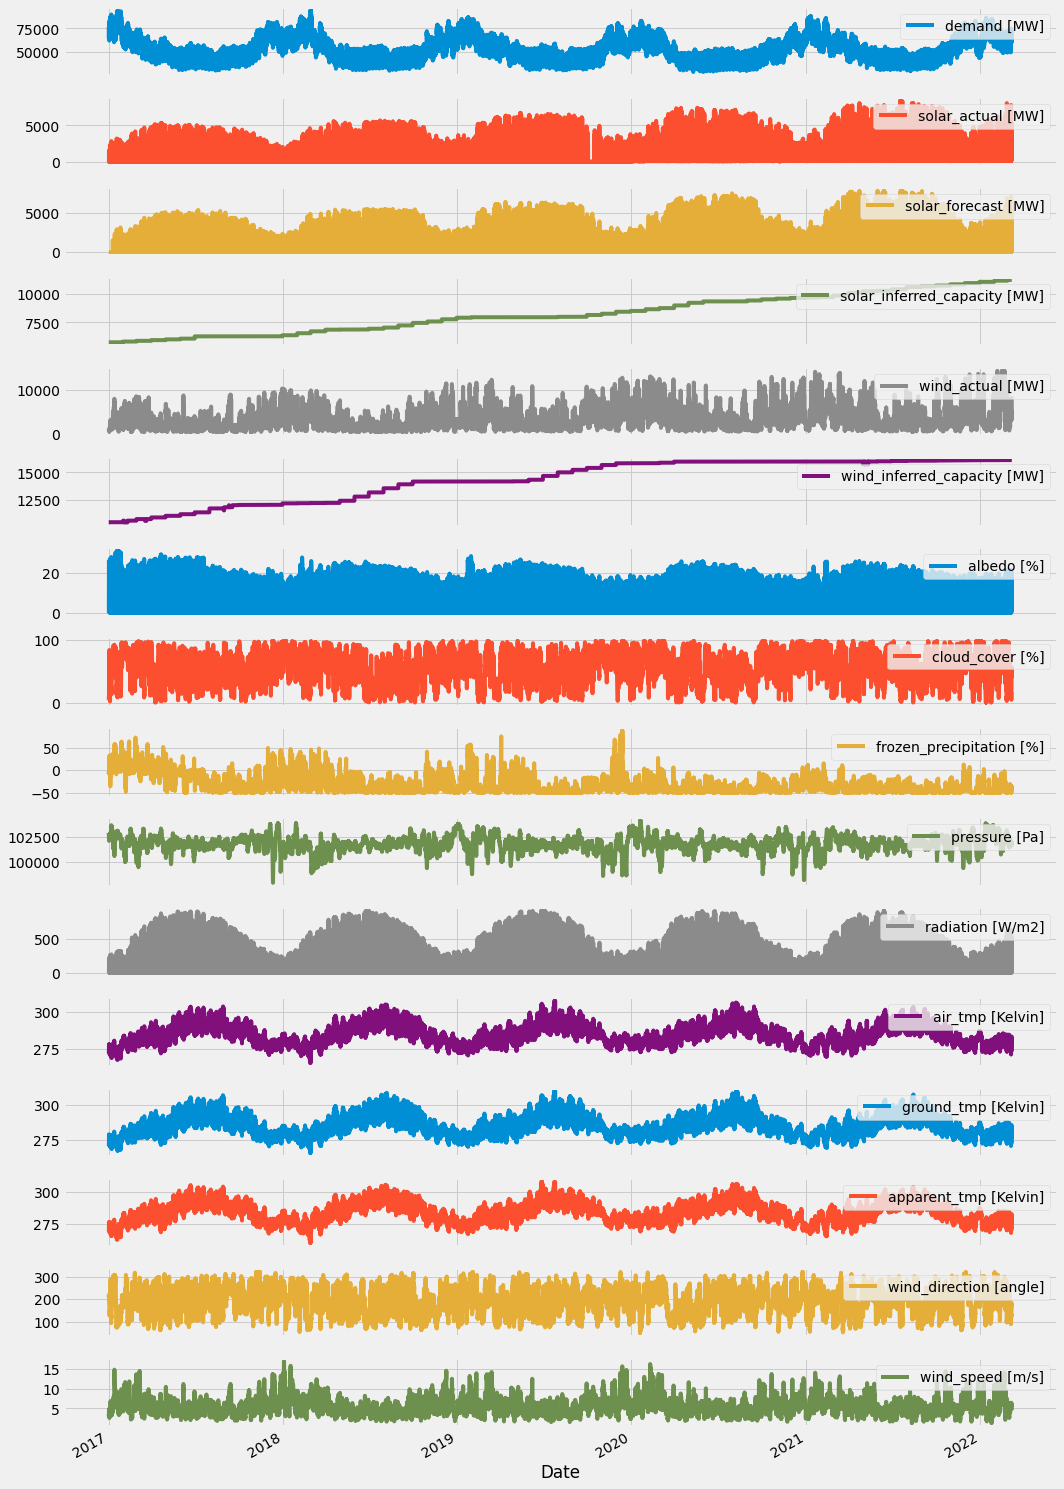

In [ ]:
ax = data1.drop(['hour', 'day', 'week',
       'month', 'weekday'], axis=1).set_index('Date')
ax[['demand [MW]', 'solar_actual [MW]', 'solar_forecast [MW]',
       'solar_inferred_capacity [MW]', 'wind_actual [MW]',
       'wind_inferred_capacity [MW]', 'albedo [%]', 'cloud_cover [%]',
       'frozen_precipitation [%]', 'pressure [Pa]', 'radiation [W/m2]',
       'air_tmp [Kelvin]', 'ground_tmp [Kelvin]', 'apparent_tmp [Kelvin]',
       'wind_direction [angle]', 'wind_speed [m/s]']].plot(subplots=True, figsize=(15,23))
[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.tight_layout()
plt.subplots_adjust(top=0.9)

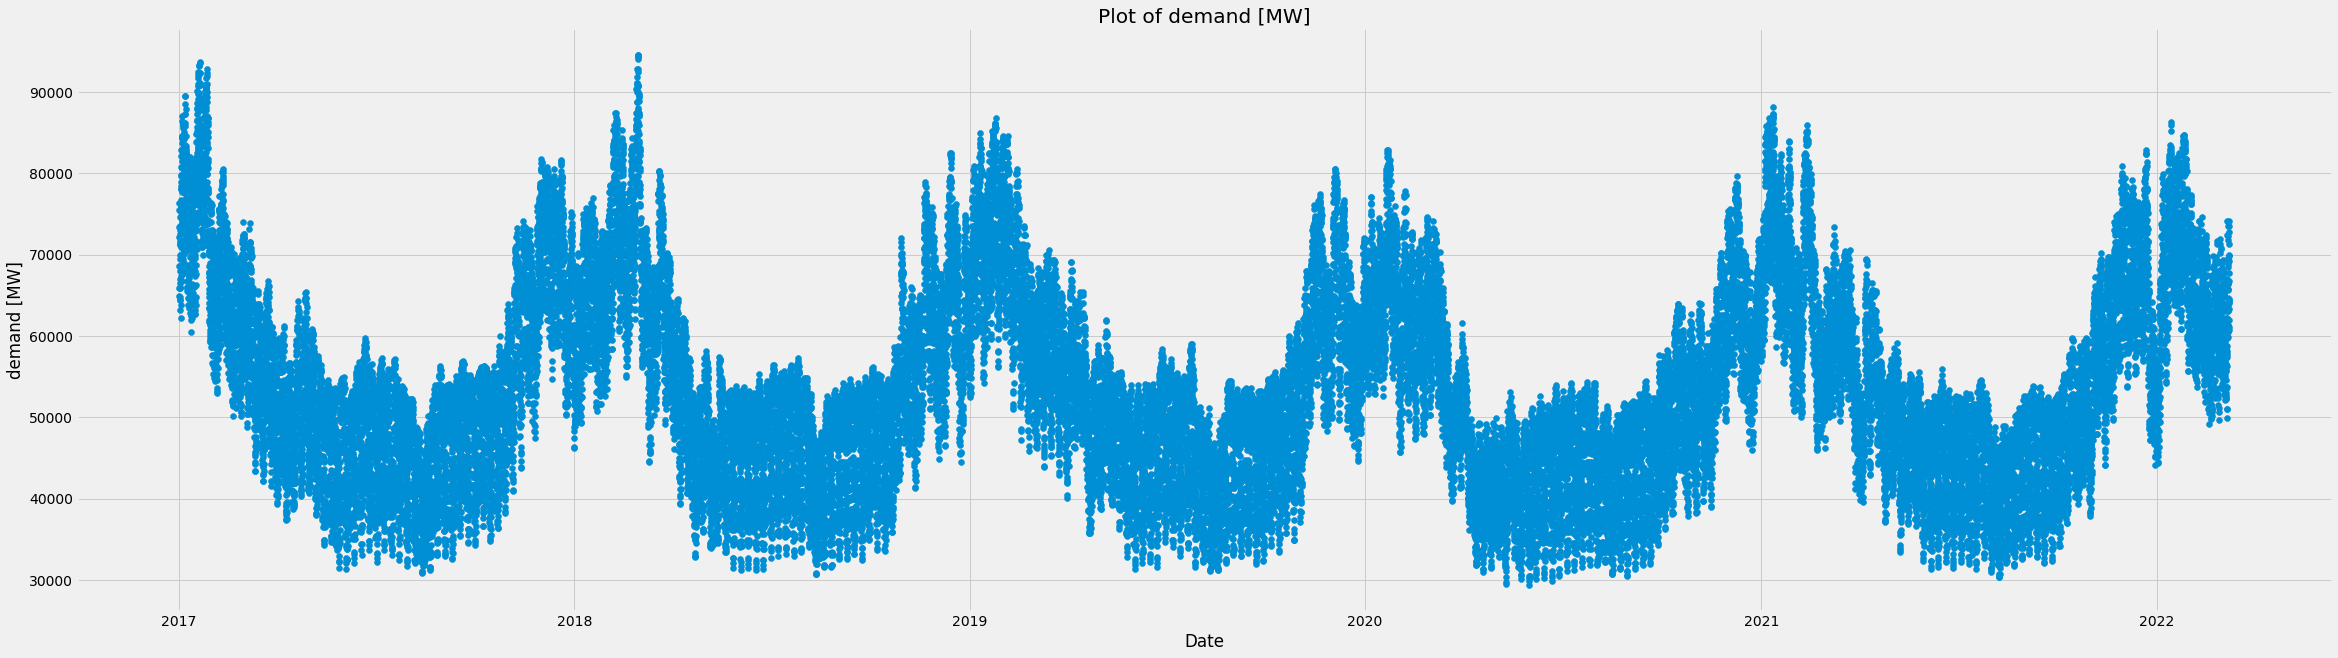

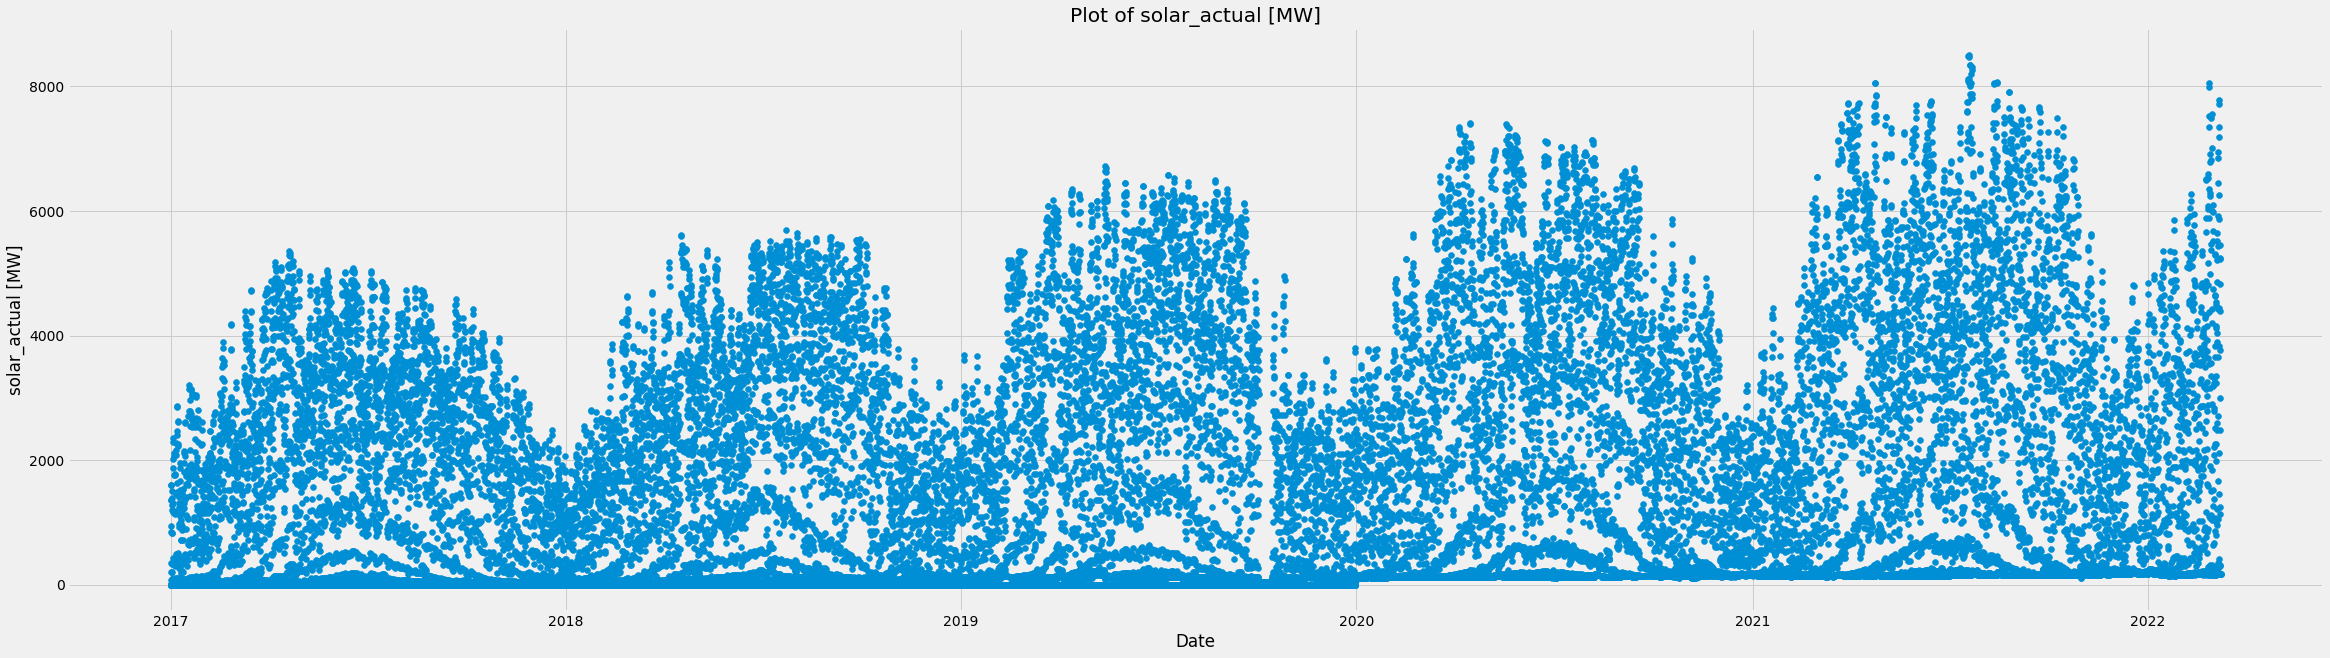

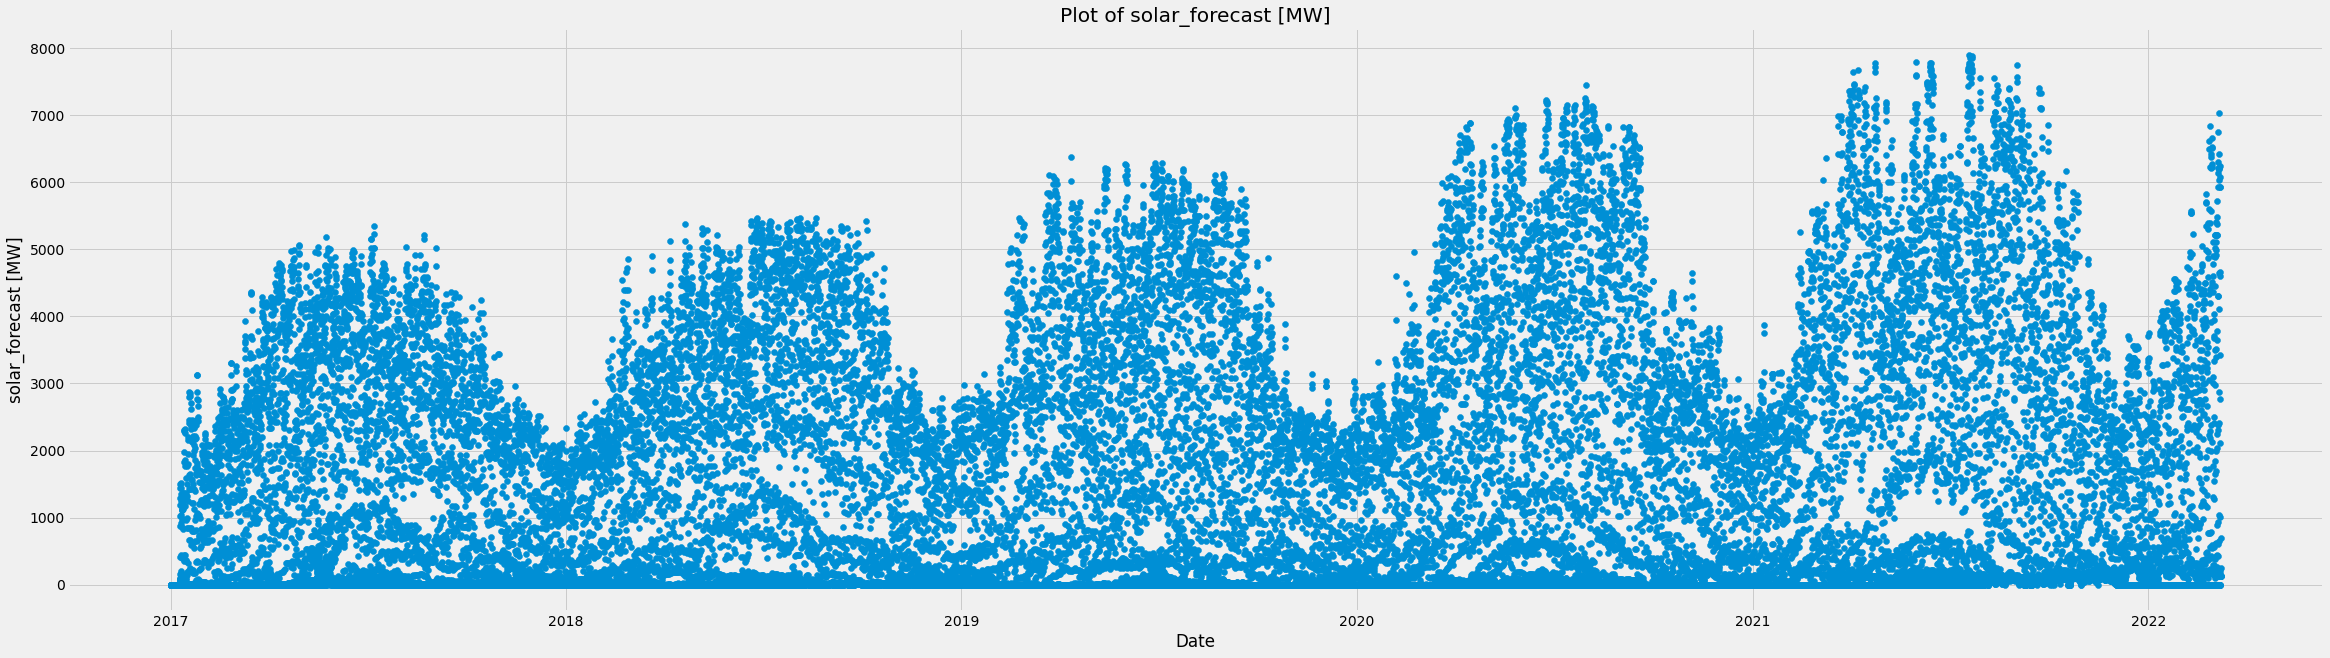

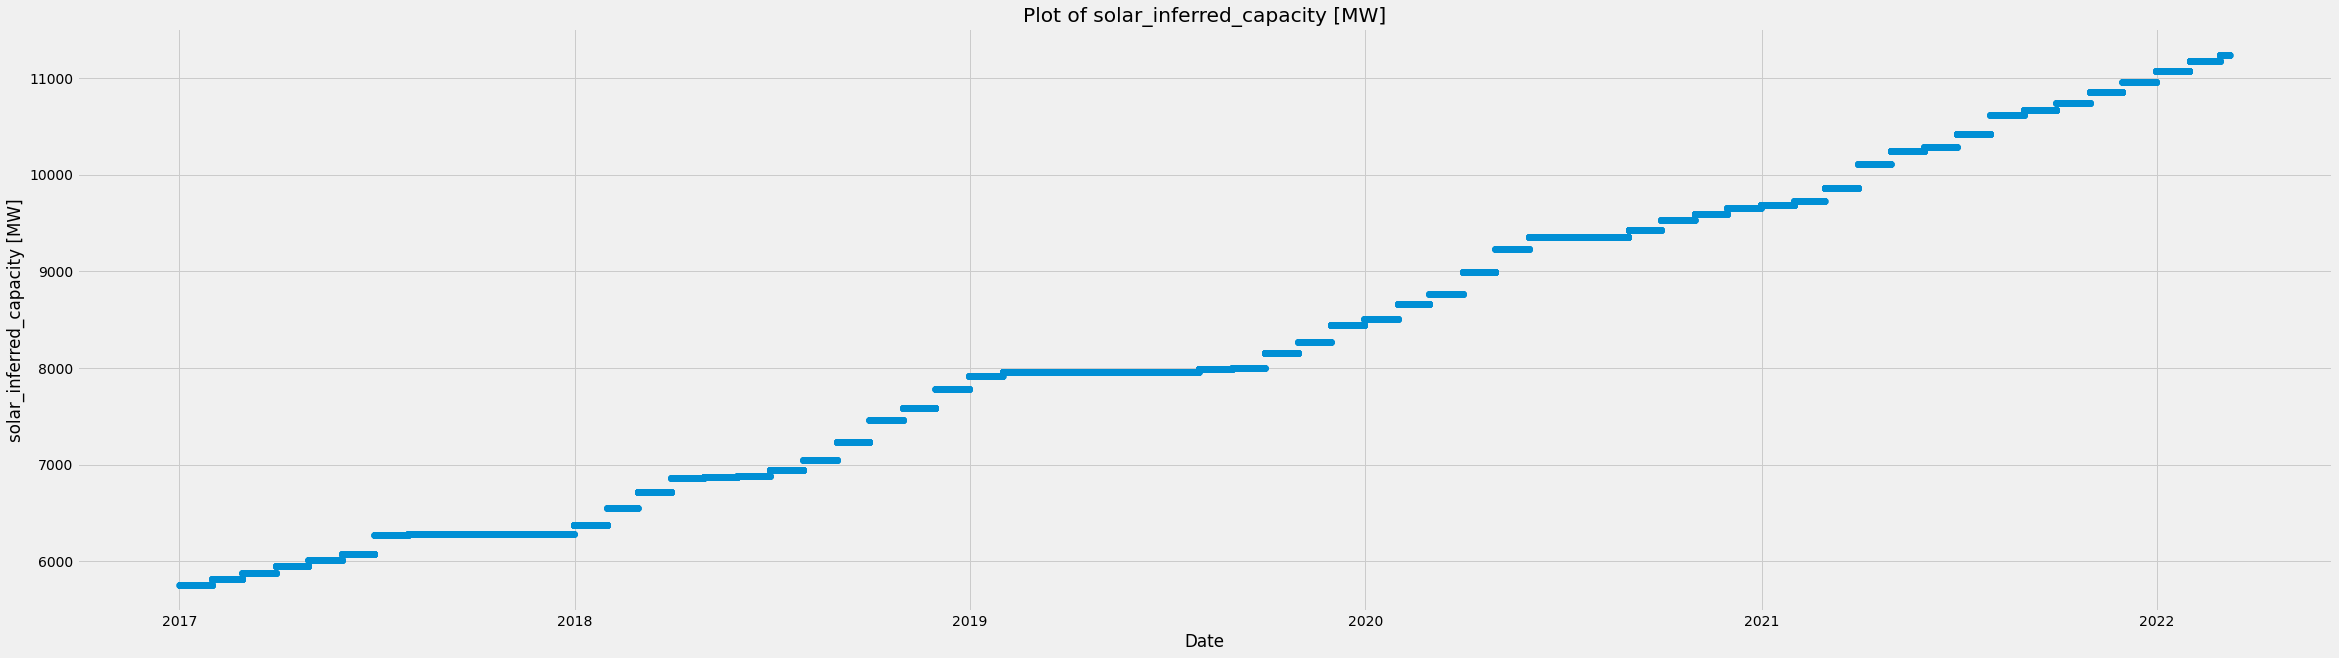

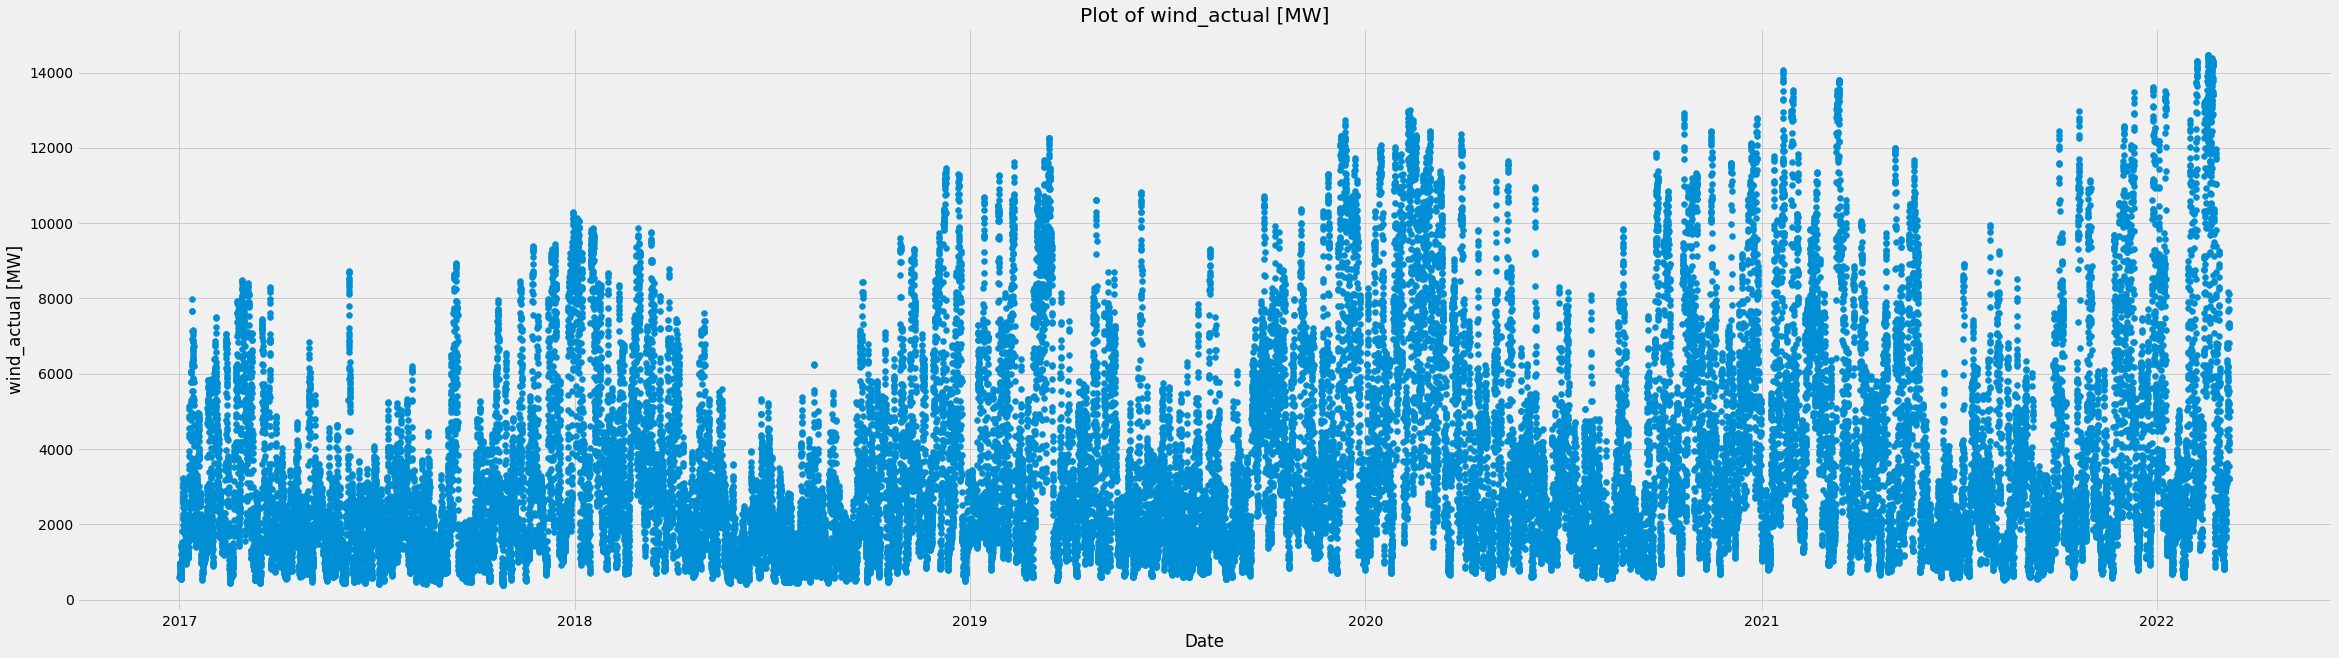

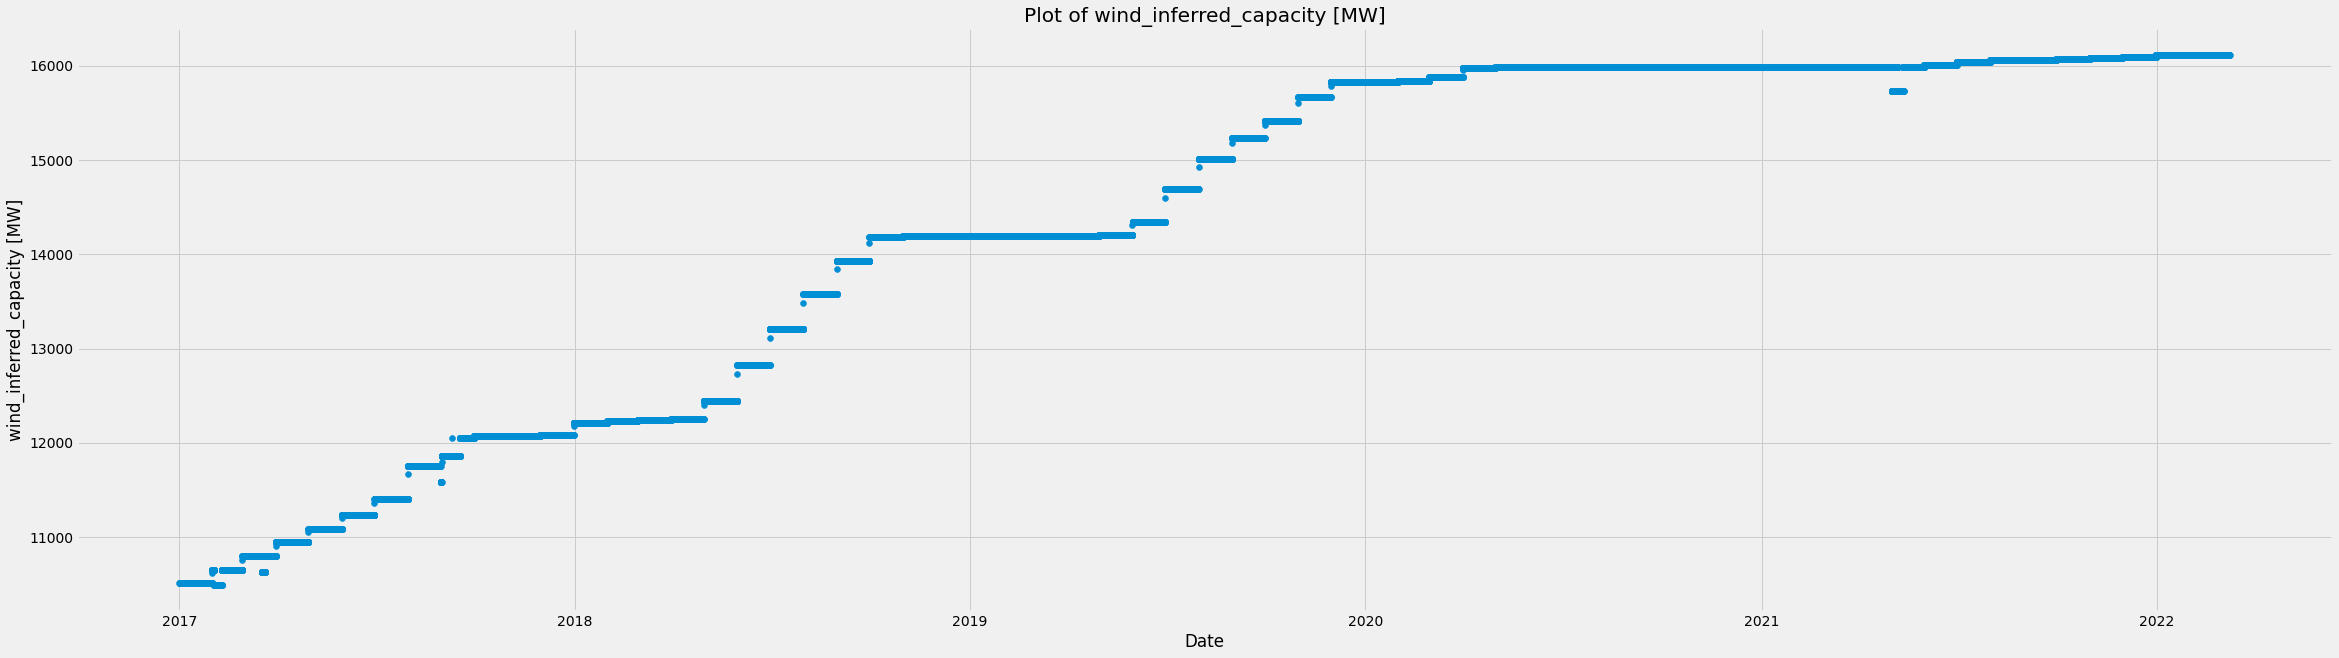

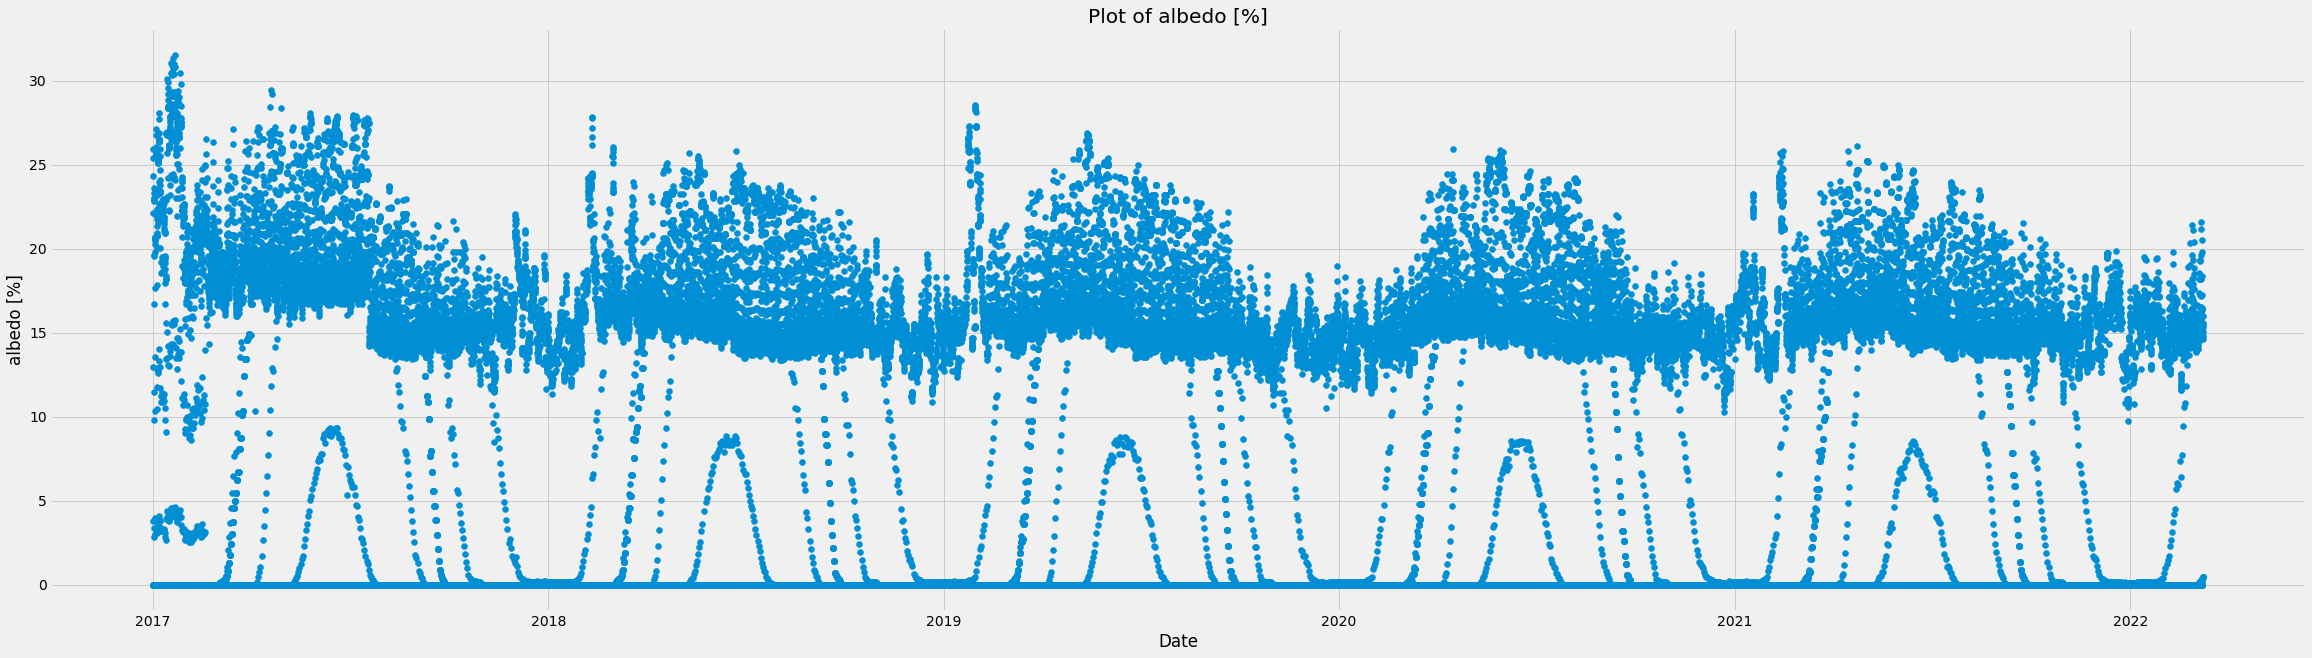

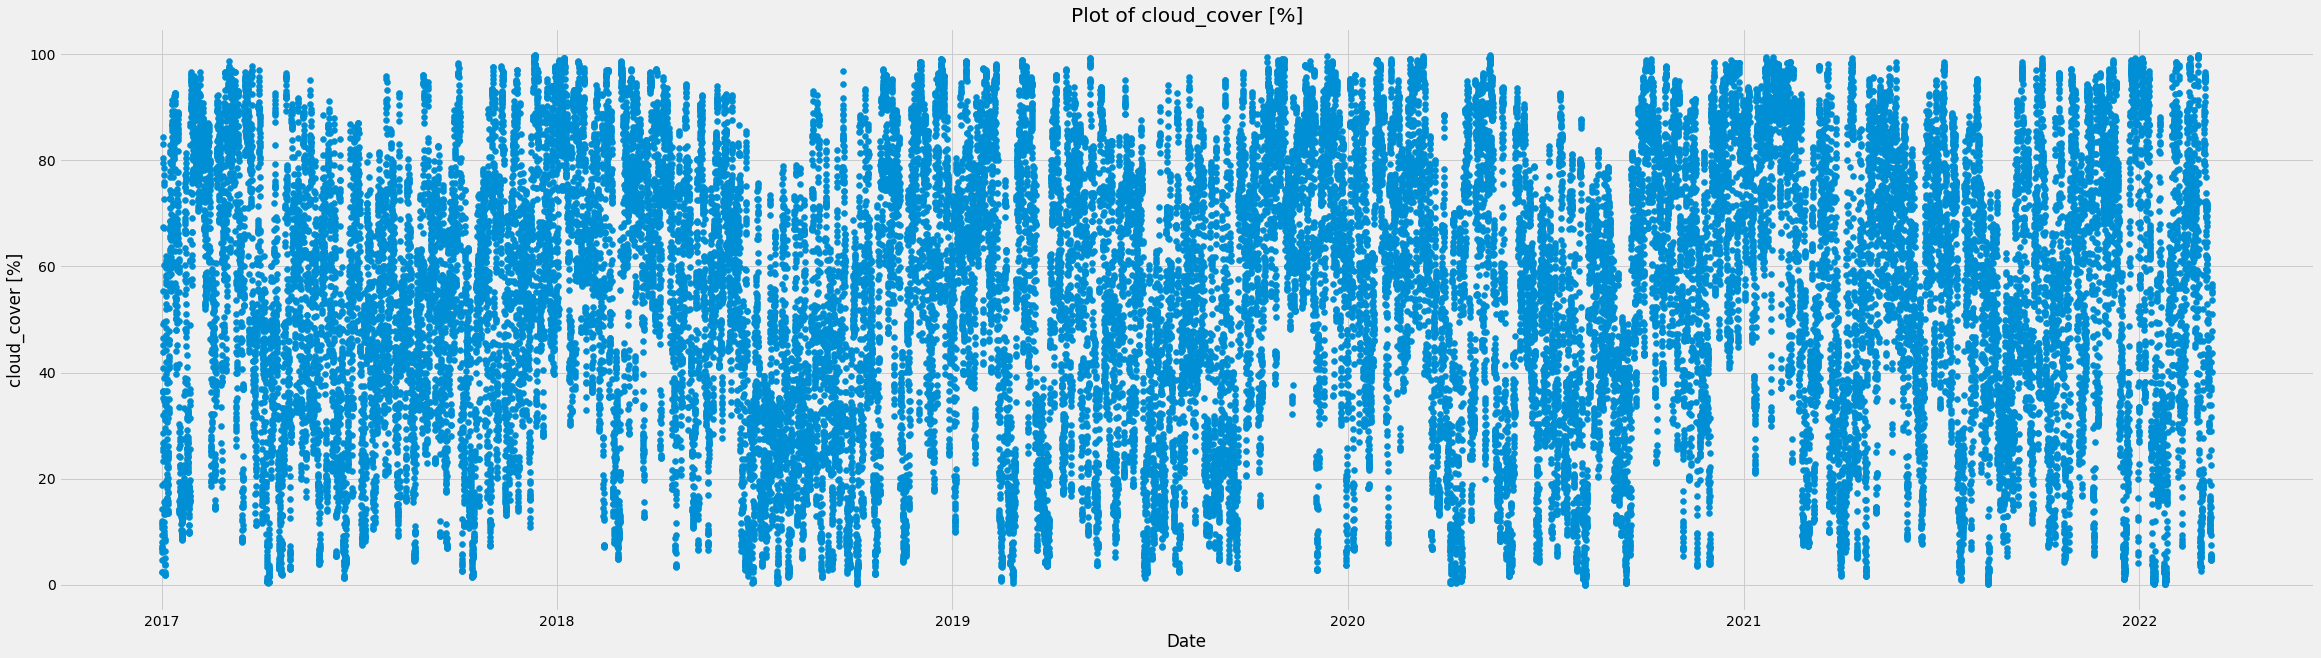

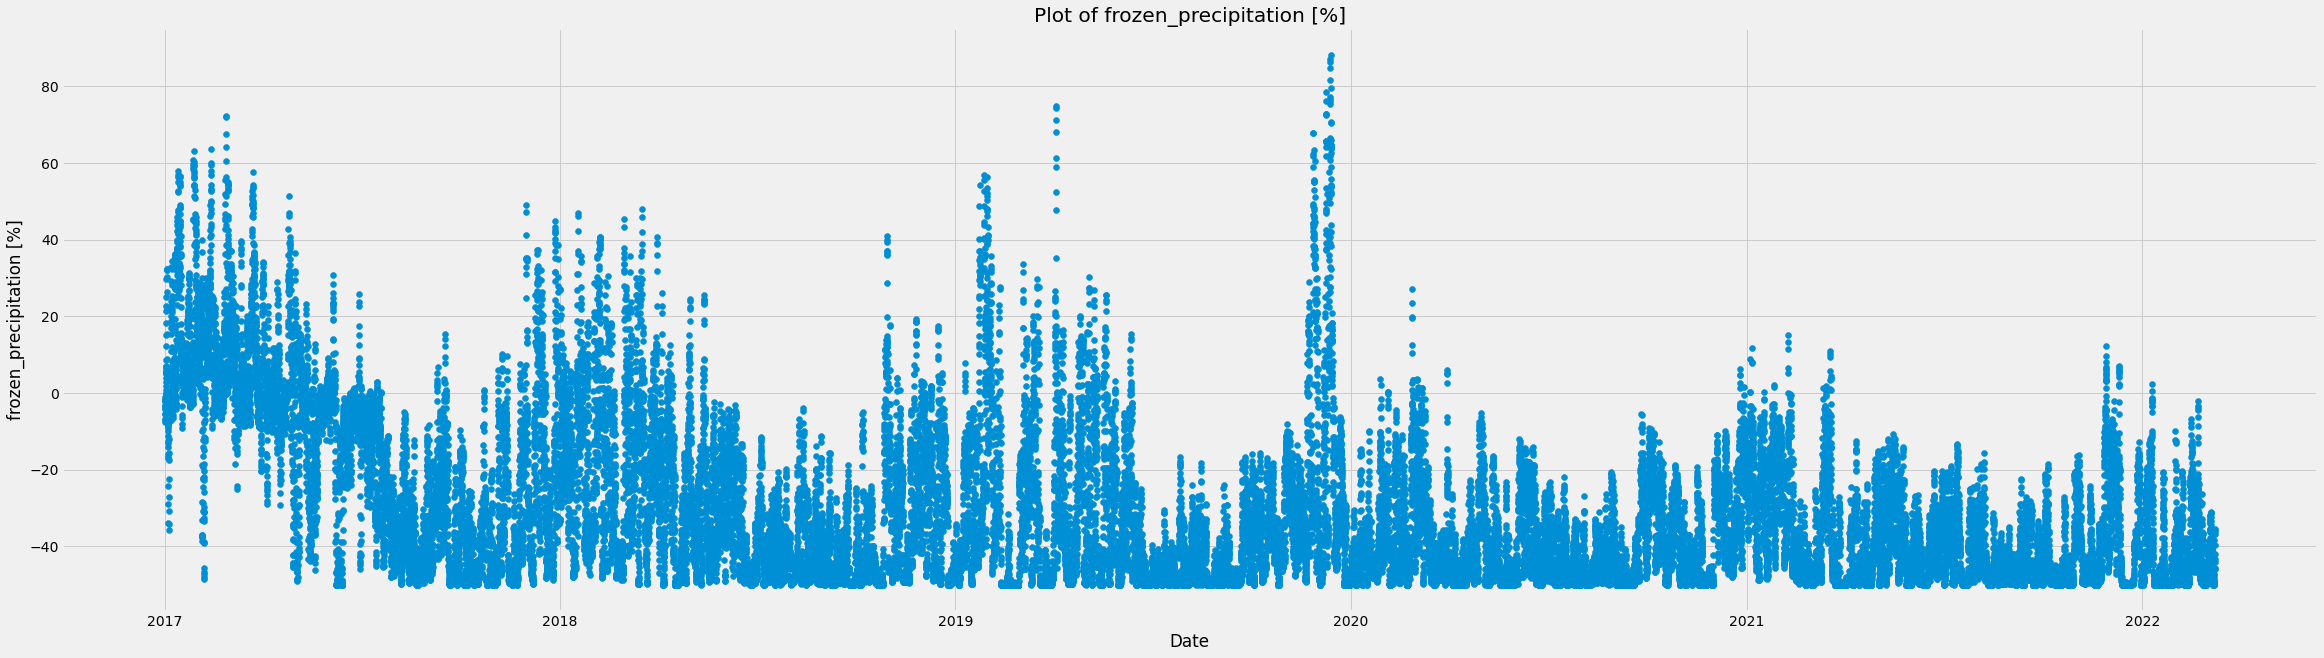

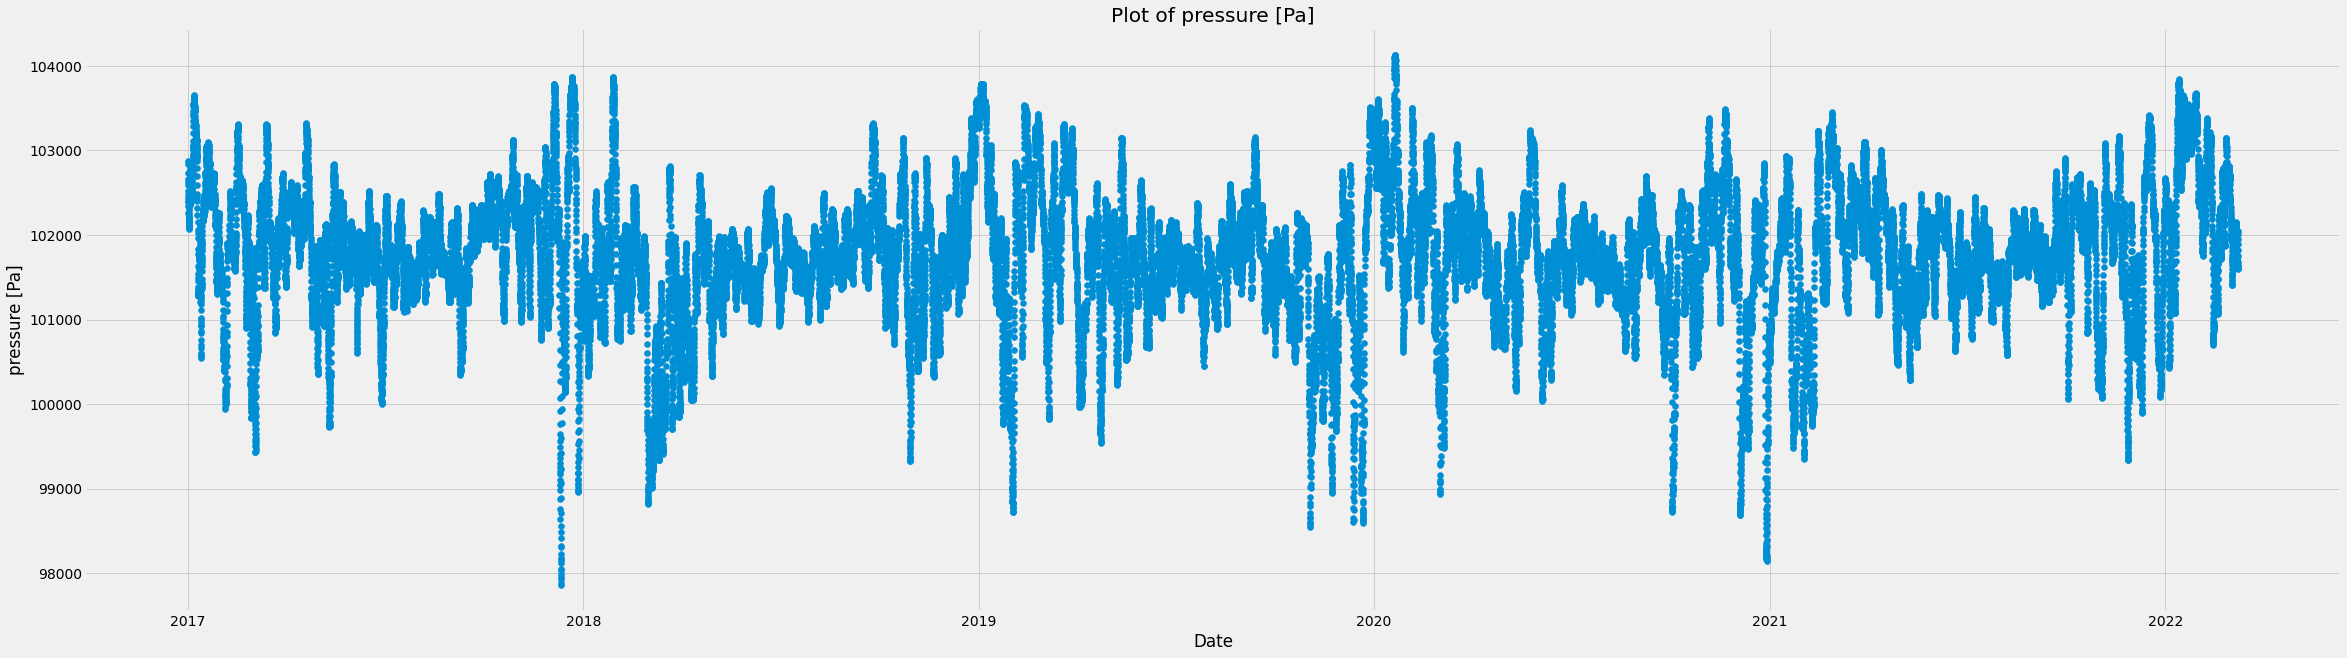

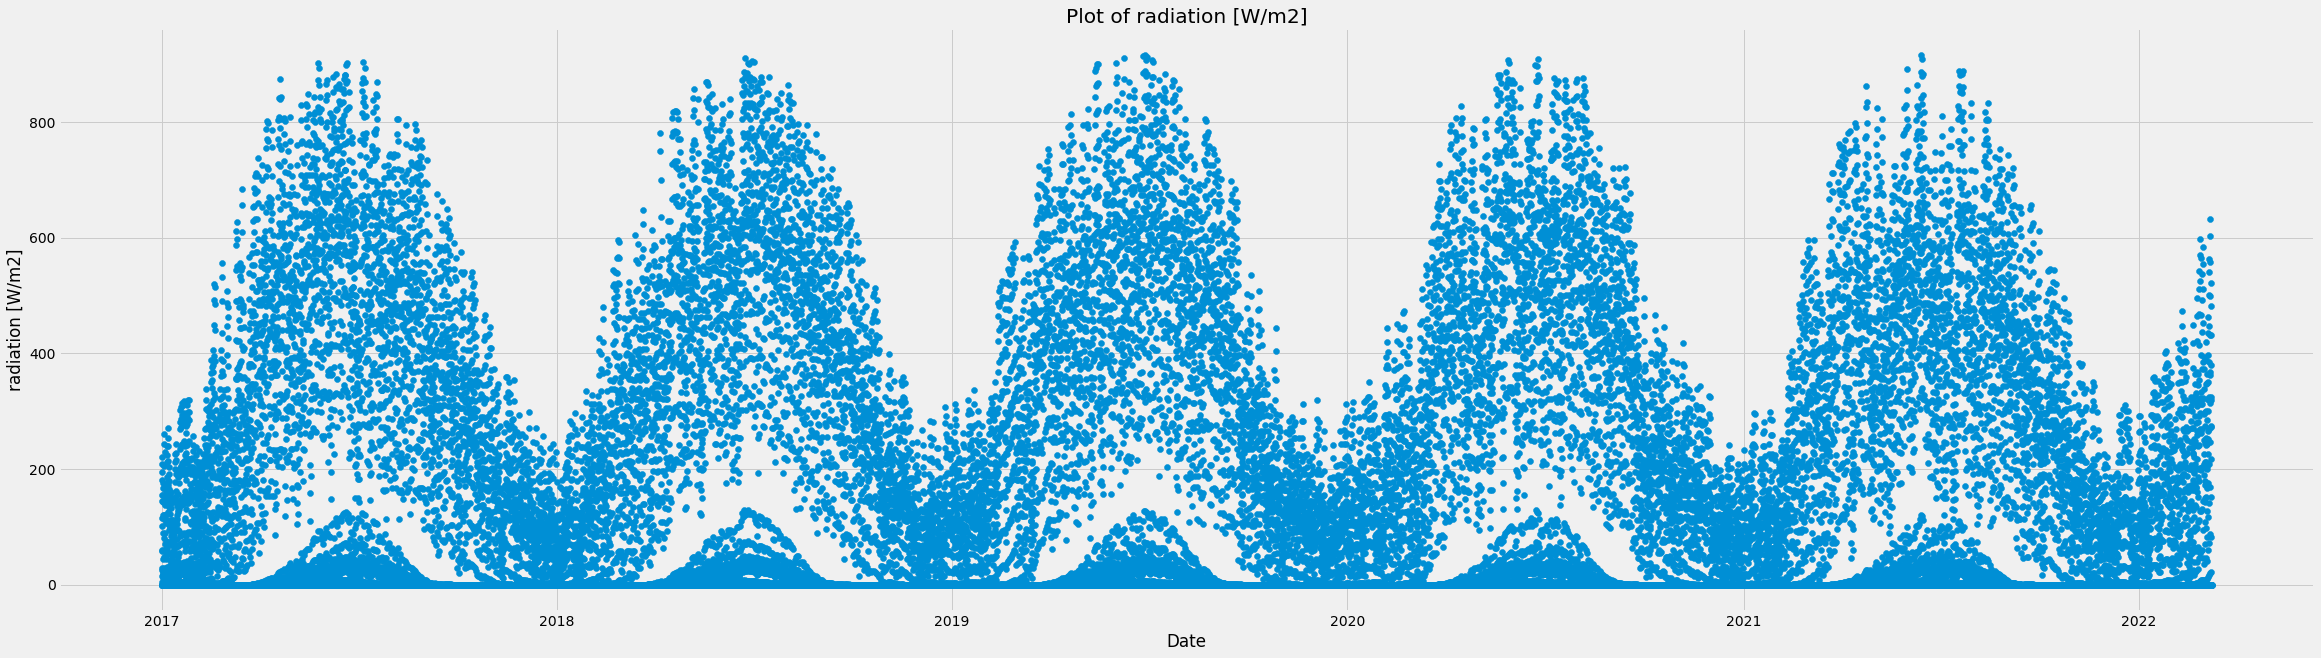

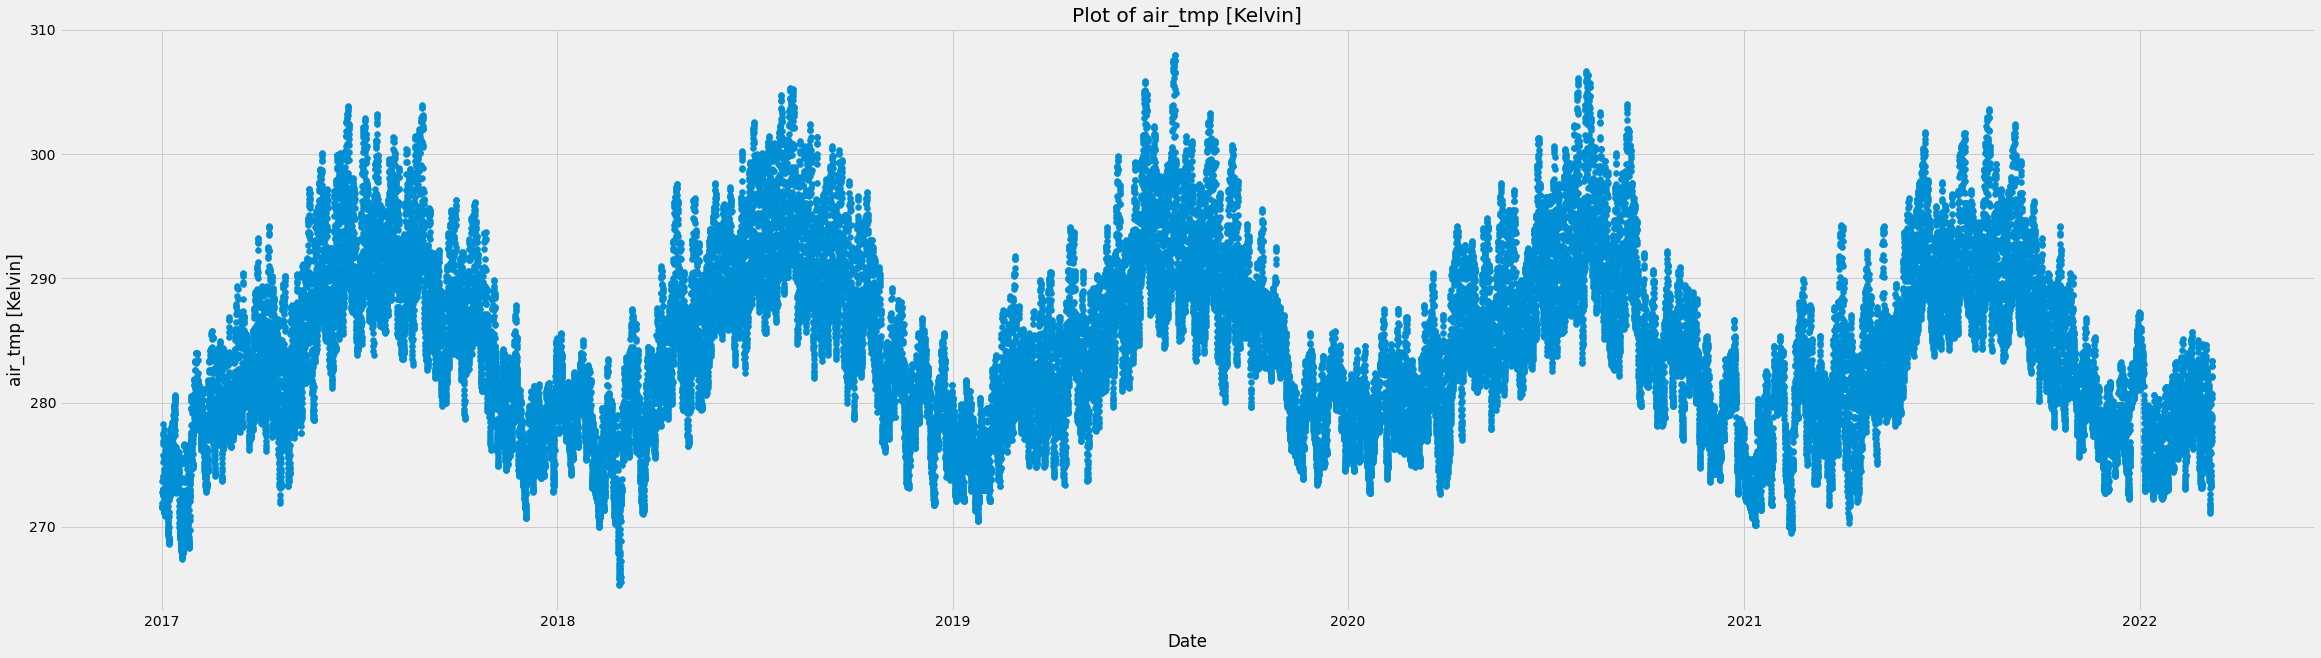

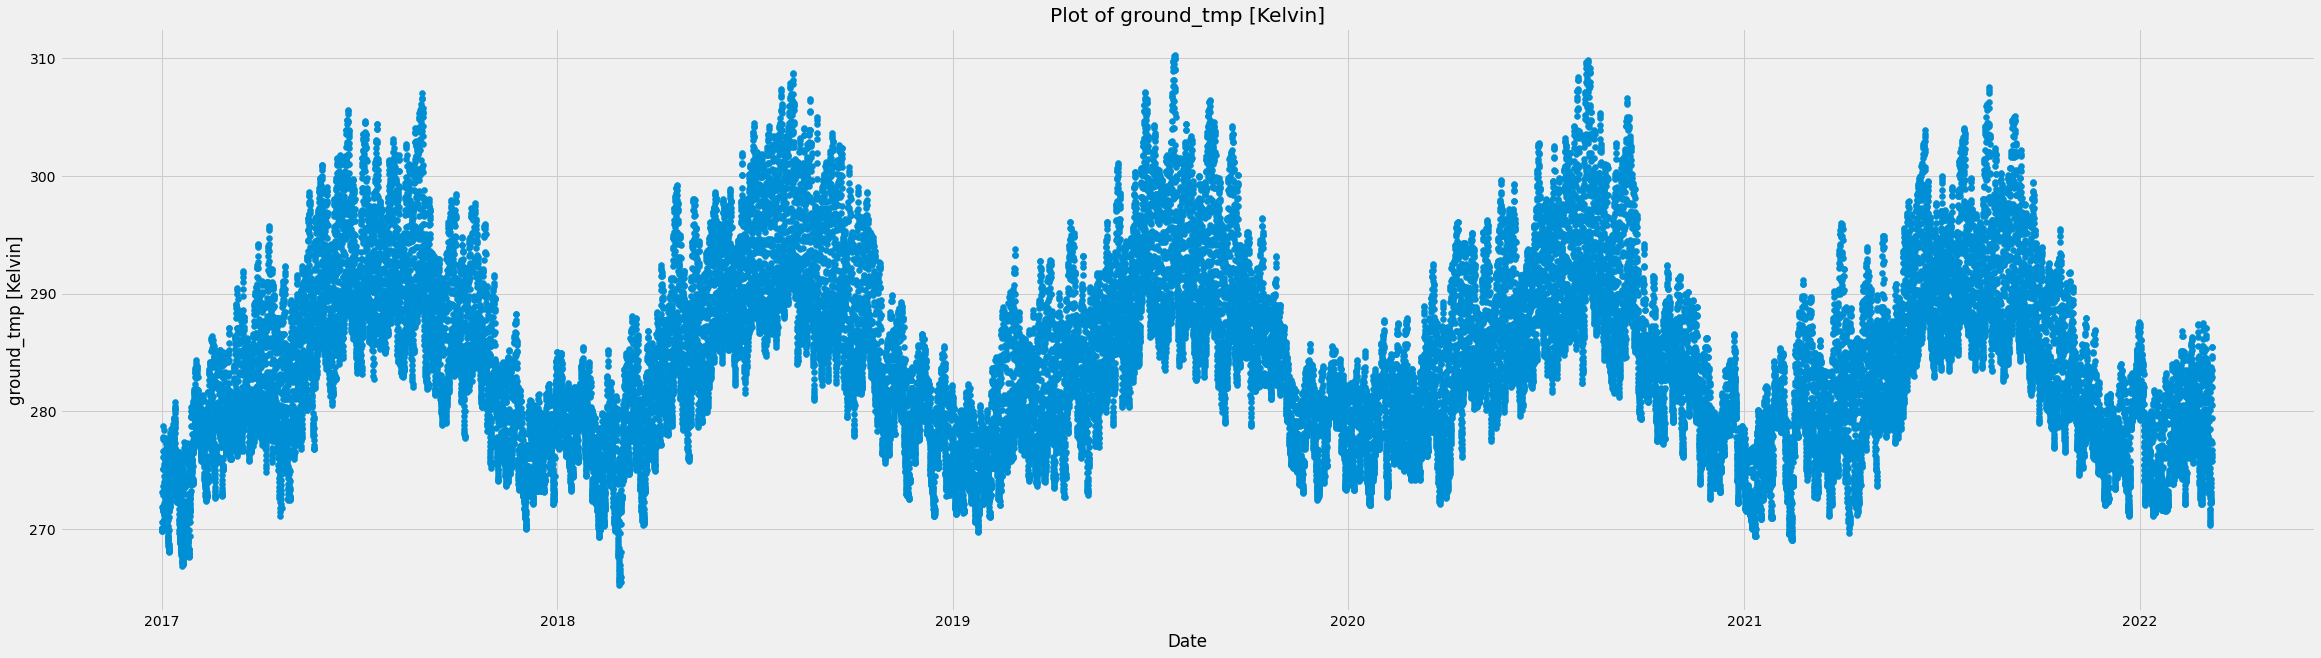

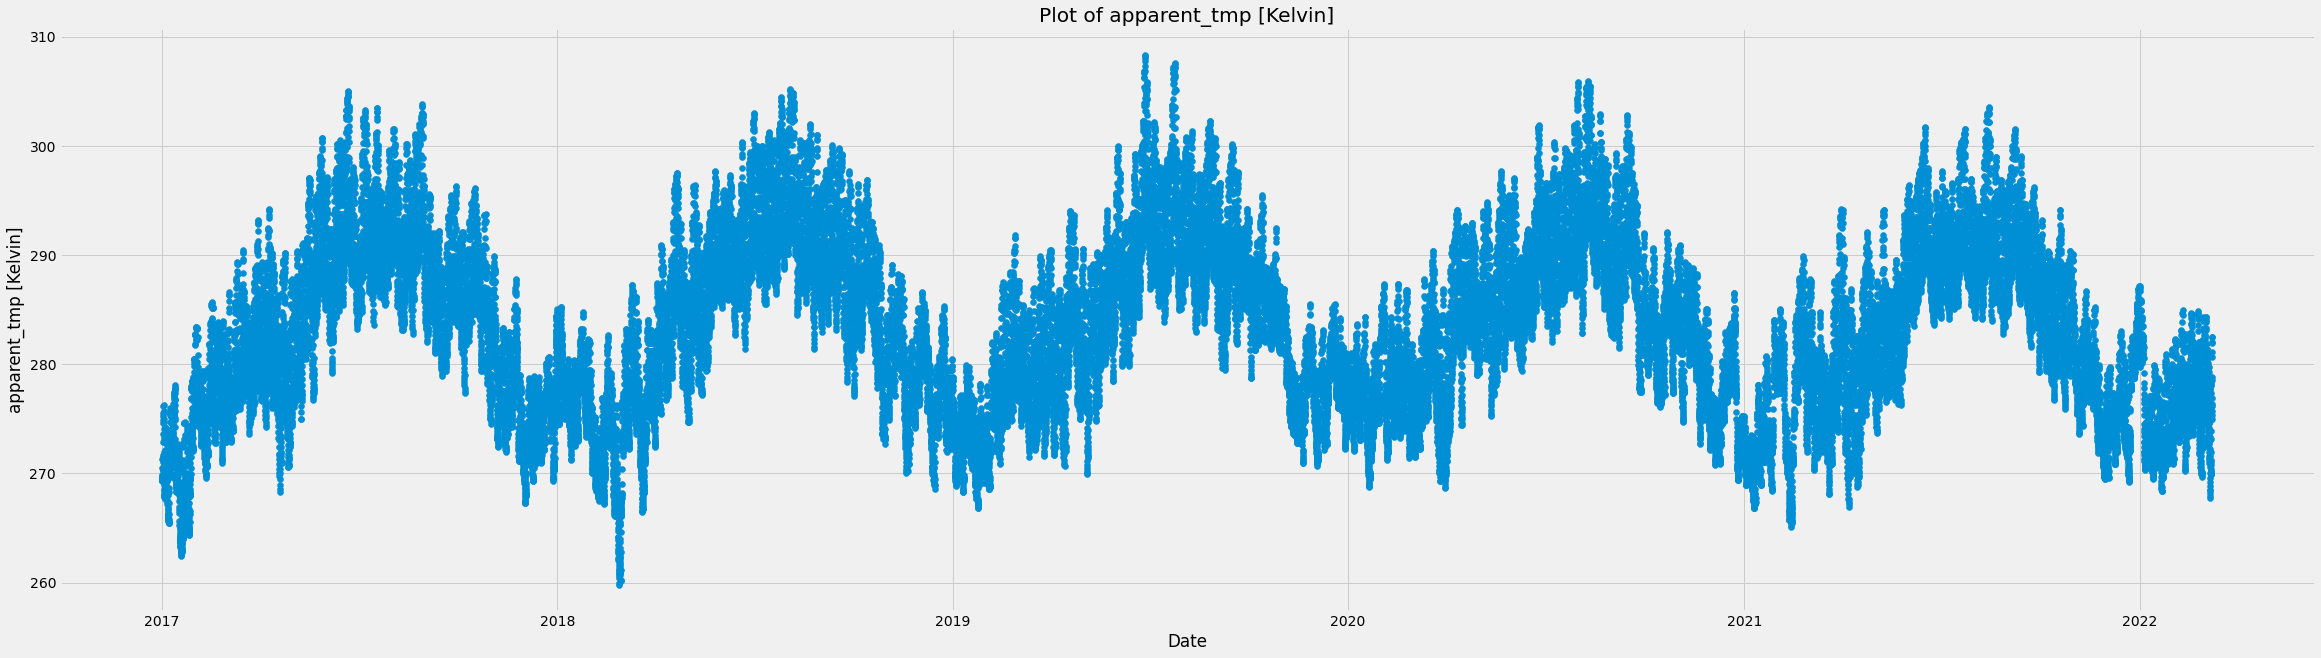

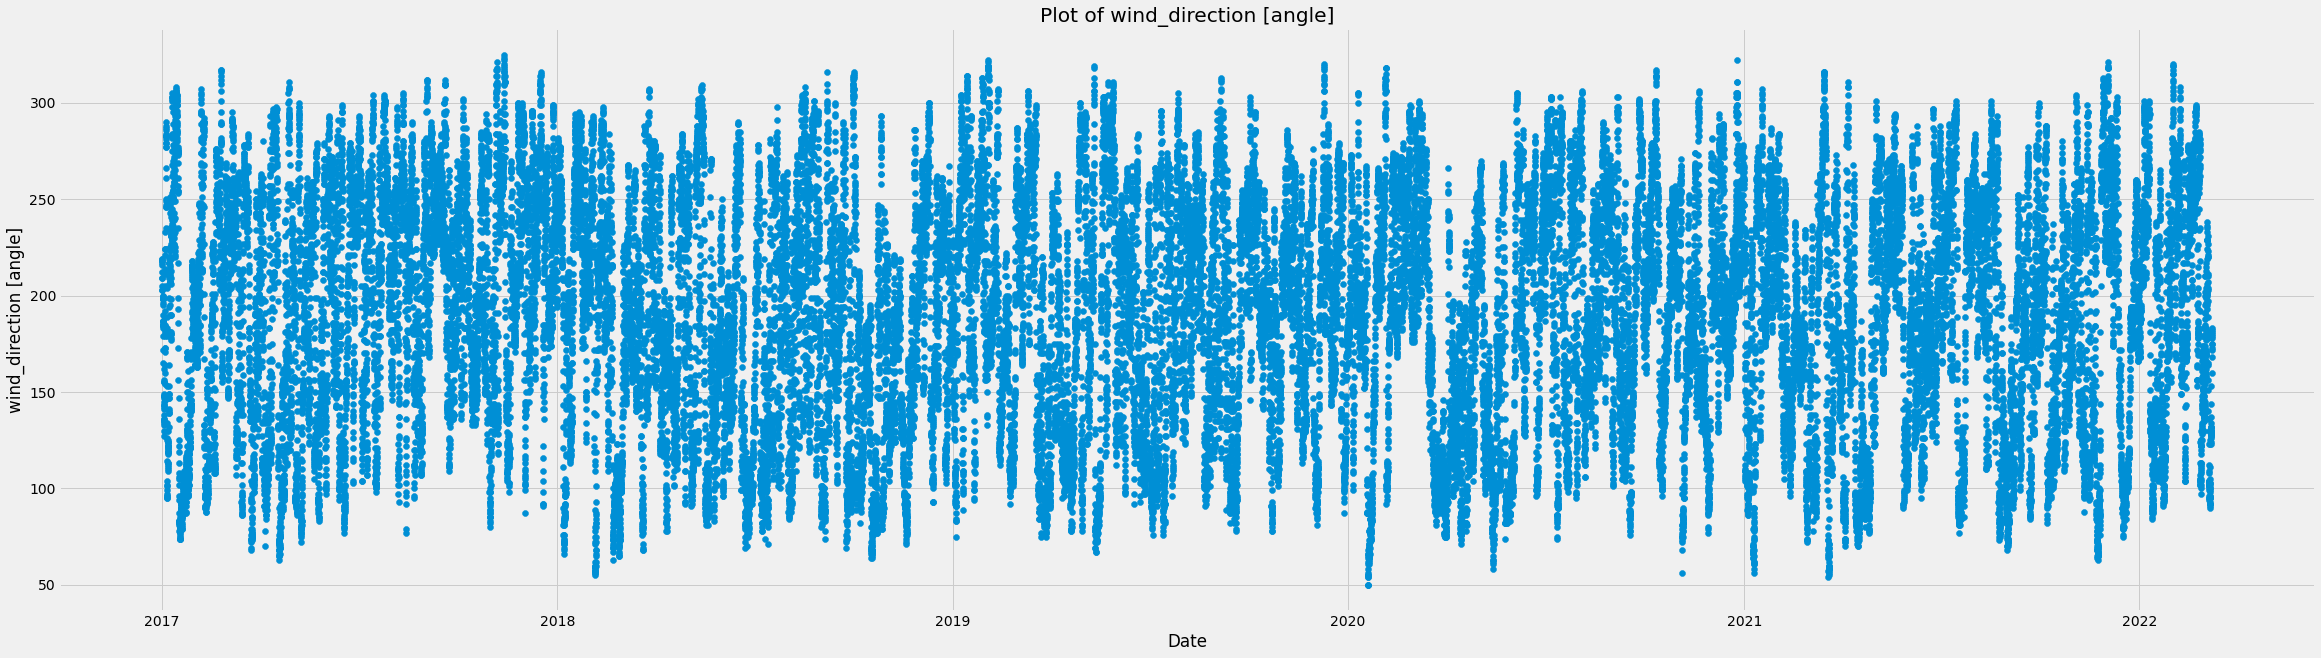

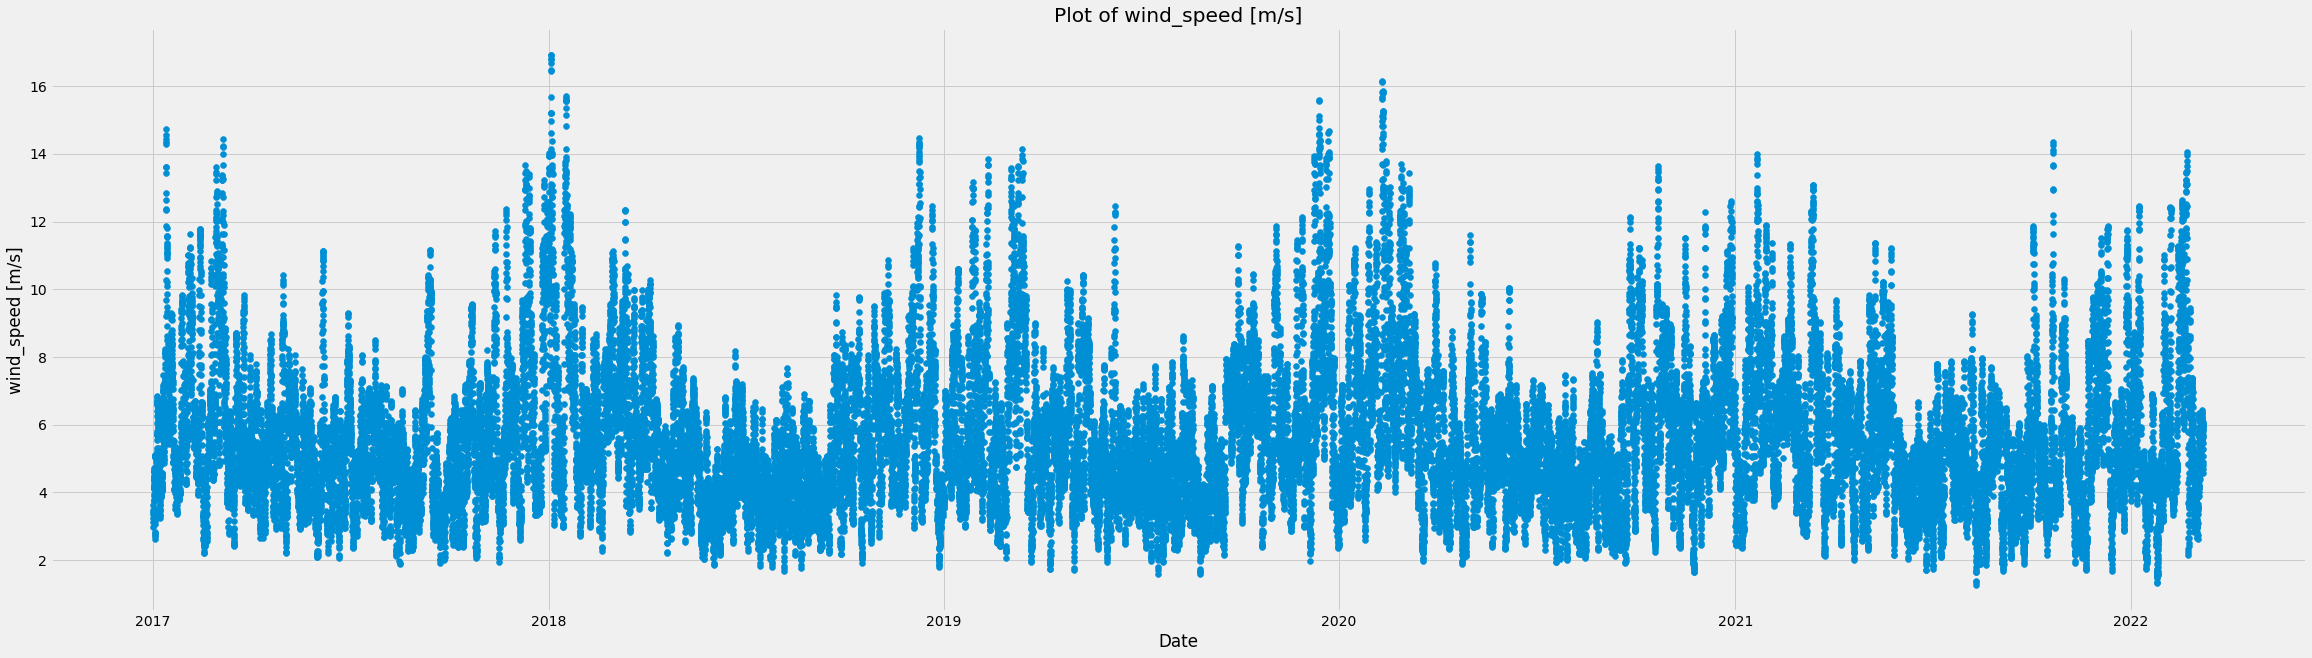

In [ ]:
plot_cols = [x for x in data1.columns if x not in ['Date', 'month', 'weekday','hour', 'day']]
for col in plot_cols:
  if col != 'week':
    plt.figure(figsize=(36,10))
    plt.scatter(data1['Date'], data1[col])
    plt.title('Plot of {}'.format(col))
    plt.xlabel('Date')
    plt.ylabel(col)

In [ ]:
used_cols = ['demand [MW]','Date','month','weekday',
             'week','day','hour','apparent_tmp [Kelvin]']
df = data1[used_cols]

#### **The plot shows the average demand and average temperature for each day of the year**

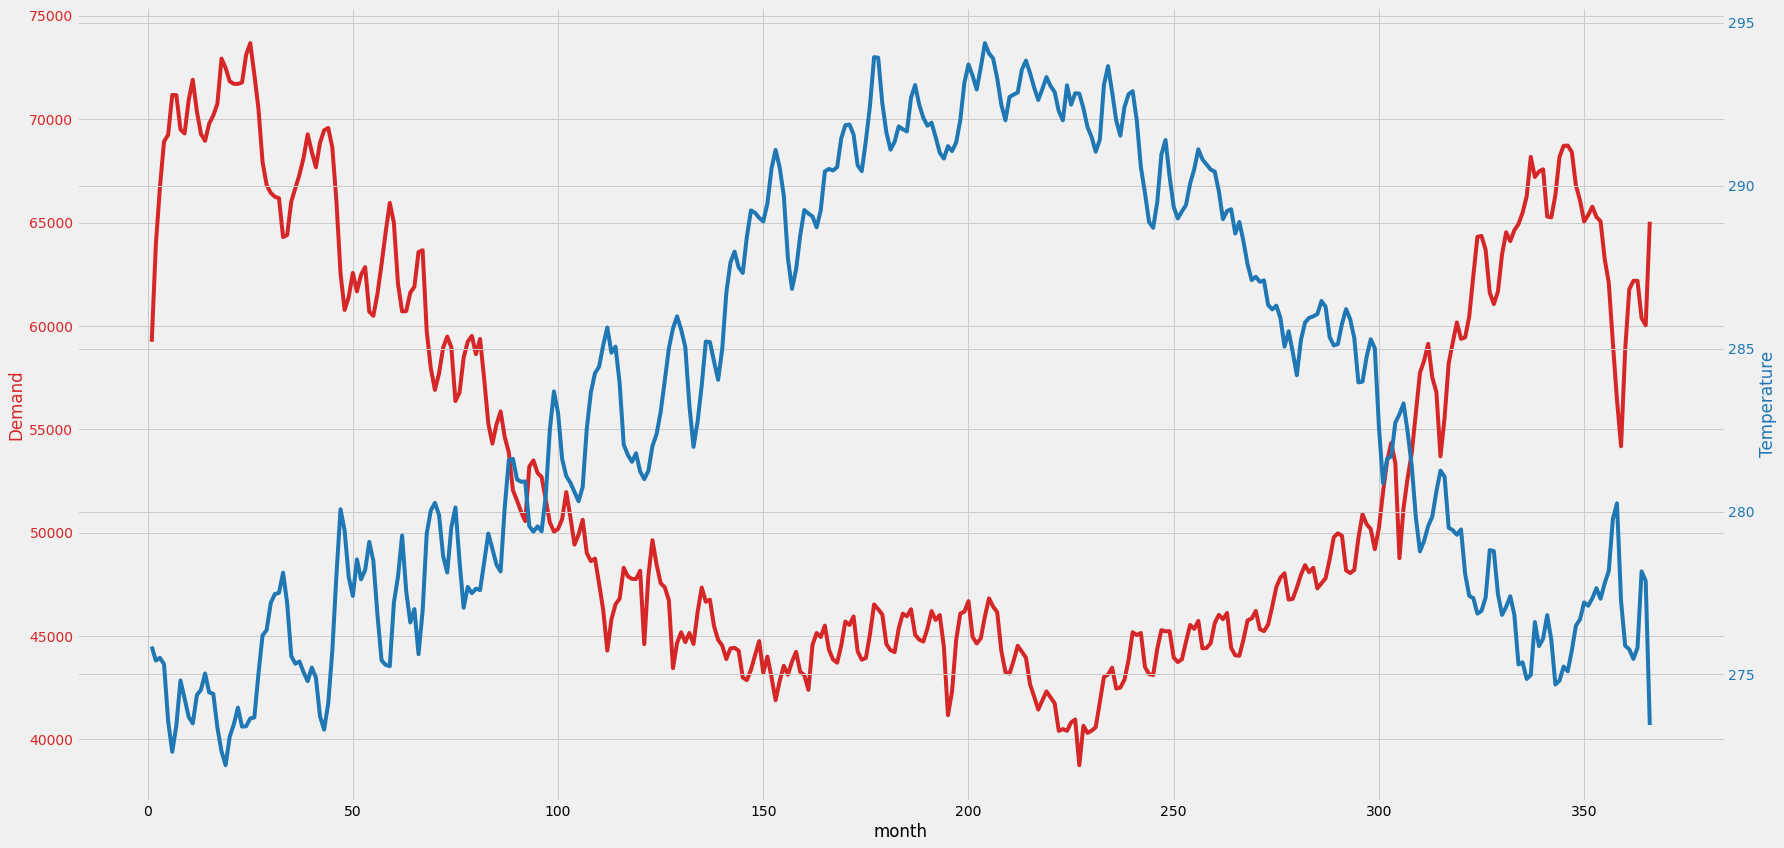

In [ ]:
daily_temp = df[['apparent_tmp [Kelvin]', 'day']].groupby('day').mean()
daily_demand = df[['demand [MW]', 'day']].groupby('day').mean()

fig, ax1 = plt.subplots(figsize=(25,12))

color = 'tab:red'
ax1.set_xlabel('month')
ax1.set_ylabel('Demand', color=color)
ax1.plot(daily_demand, color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Temperature', color=color)  
ax2.plot(daily_temp, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()

### **The plot shows the average demand and average temperature for each month**

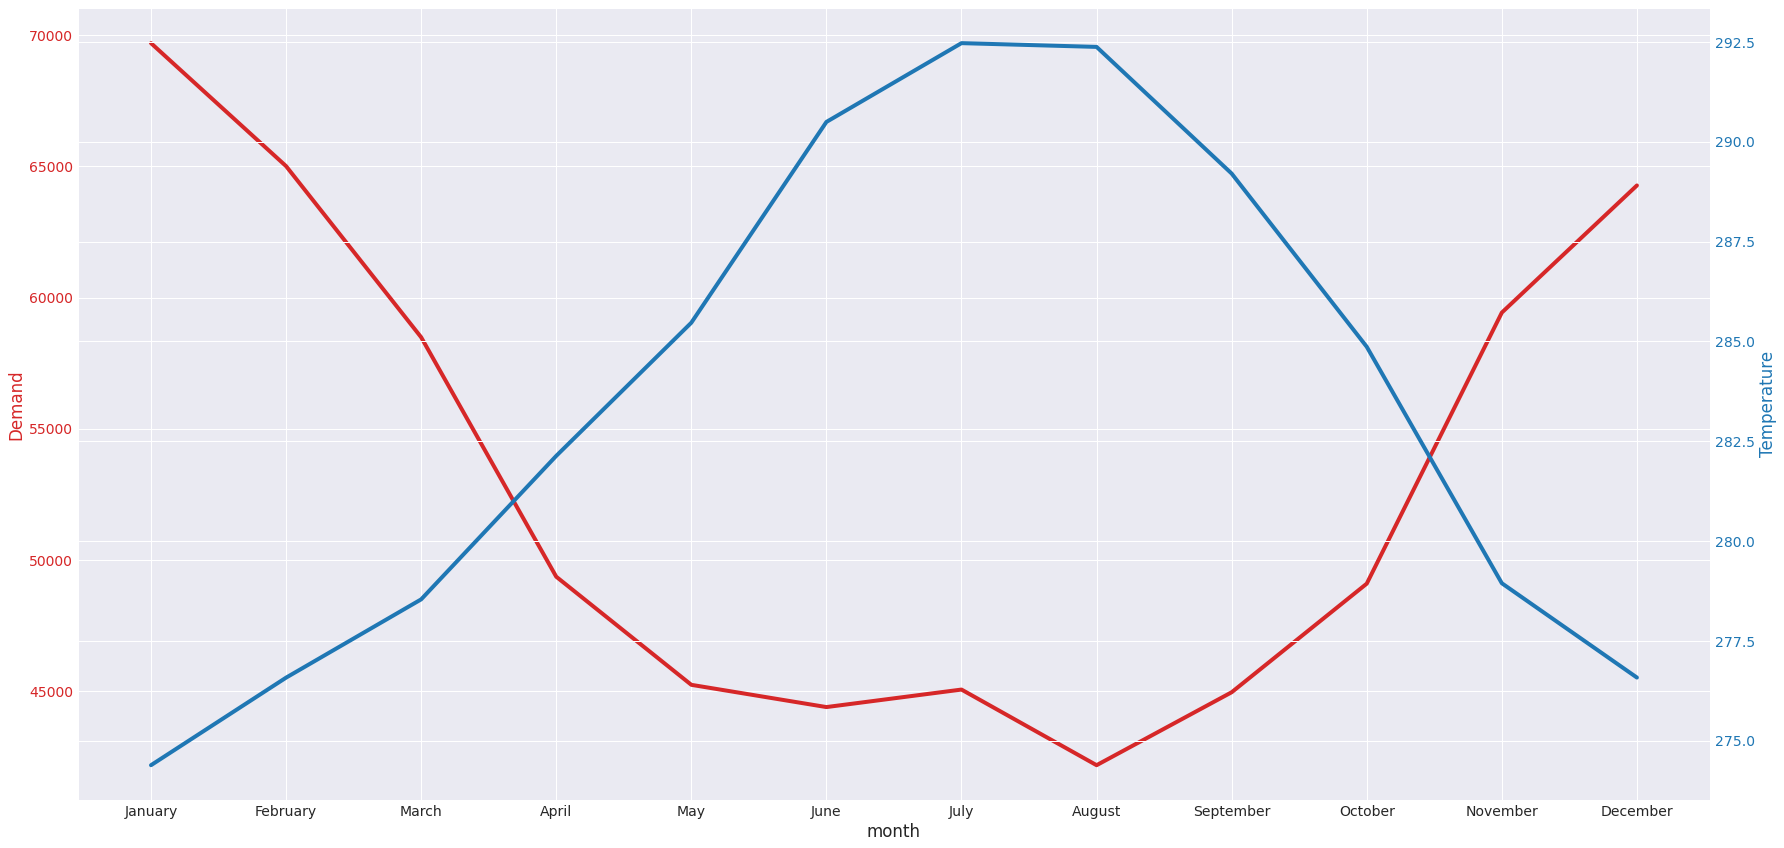

In [ ]:
month_demand = df[['demand [MW]', 'month']].groupby('month').mean().reset_index()
month_demand = sd.Sort_Dataframeby_Month(month_demand, 'month')
month_demand = month_demand.set_index('month')

month_temp = df[['apparent_tmp [Kelvin]', 'month']].groupby('month').mean().reset_index()
month_temp = sd.Sort_Dataframeby_Month(month_temp, 'month')
month_temp = month_temp.set_index('month')
sns.set_style('darkgrid')

fig, ax1 = plt.subplots(figsize=(25,12))

color = 'tab:red'
ax1.set_xlabel('month')
ax1.set_ylabel('Demand', color=color)
ax1.plot(month_demand, color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Temperature', color=color)  
ax2.plot(month_temp, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()

### **The plot shows the average demand and average temperature for each week**

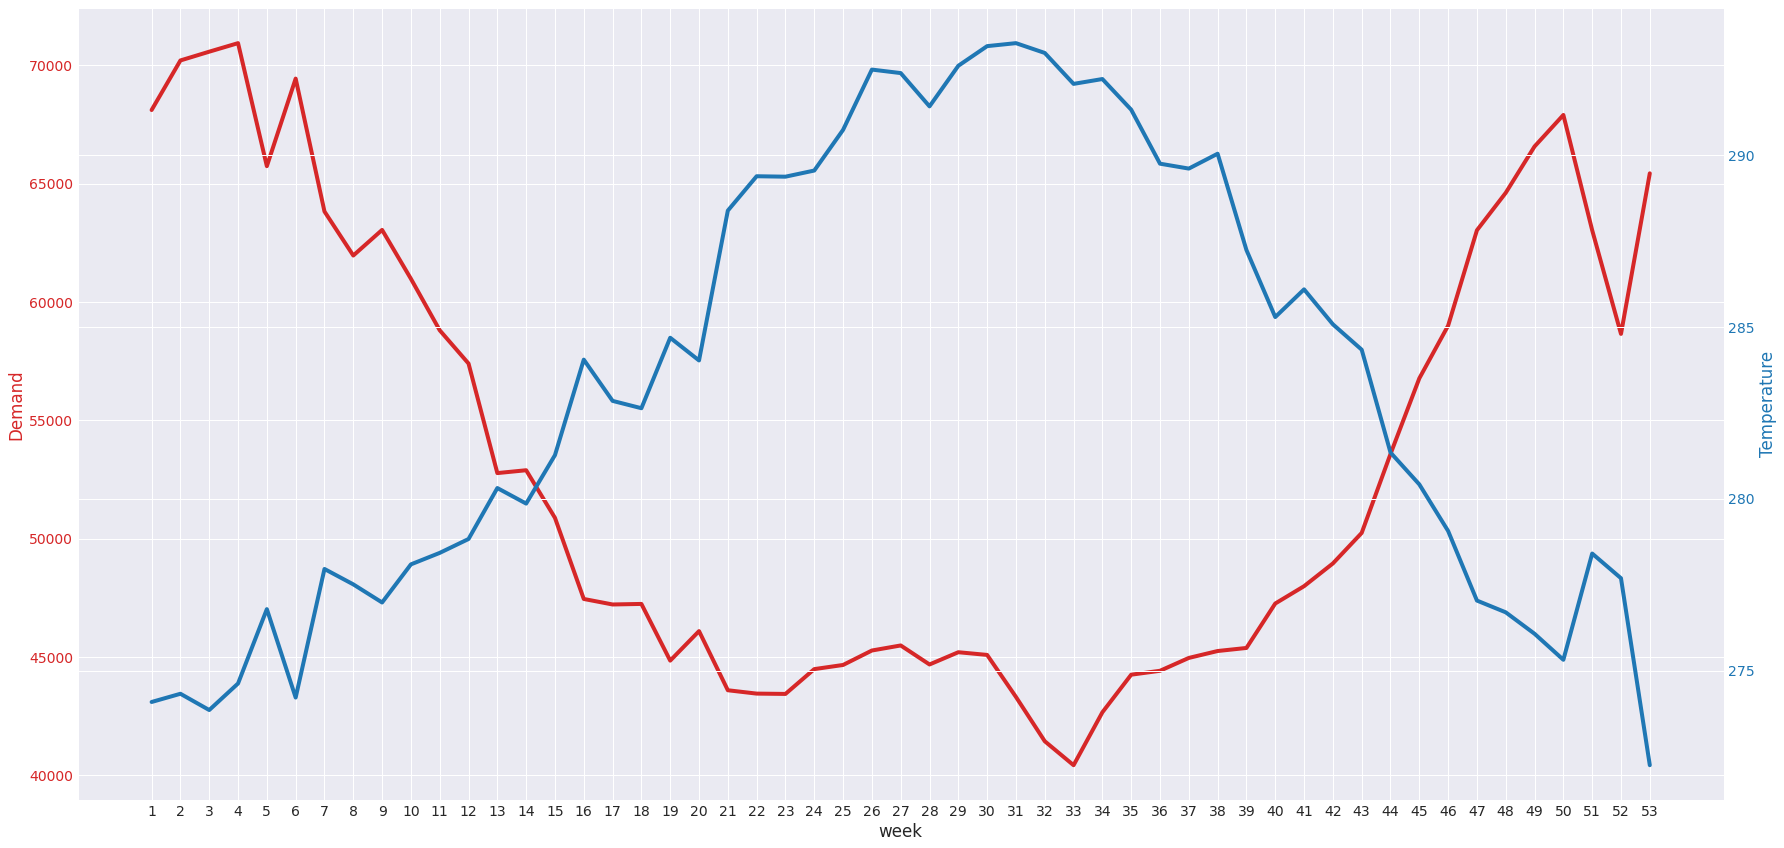

In [ ]:
weekly_demand = df[['demand [MW]', 'week', 'weekday']].groupby('week').mean()

weekly_temp = df[['apparent_tmp [Kelvin]', 'week', 'weekday']].groupby('week').mean()

fig, ax1 = plt.subplots(figsize=(25,12))

color = 'tab:red'
ax1.set_xlabel('week')
ax1.set_ylabel('Demand', color=color)
ax1.plot(weekly_demand, color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(weekly_temp.index)
ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Temperature', color=color)  
ax2.plot(weekly_temp, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()

### **Demand for each weekday on an hourly bases**

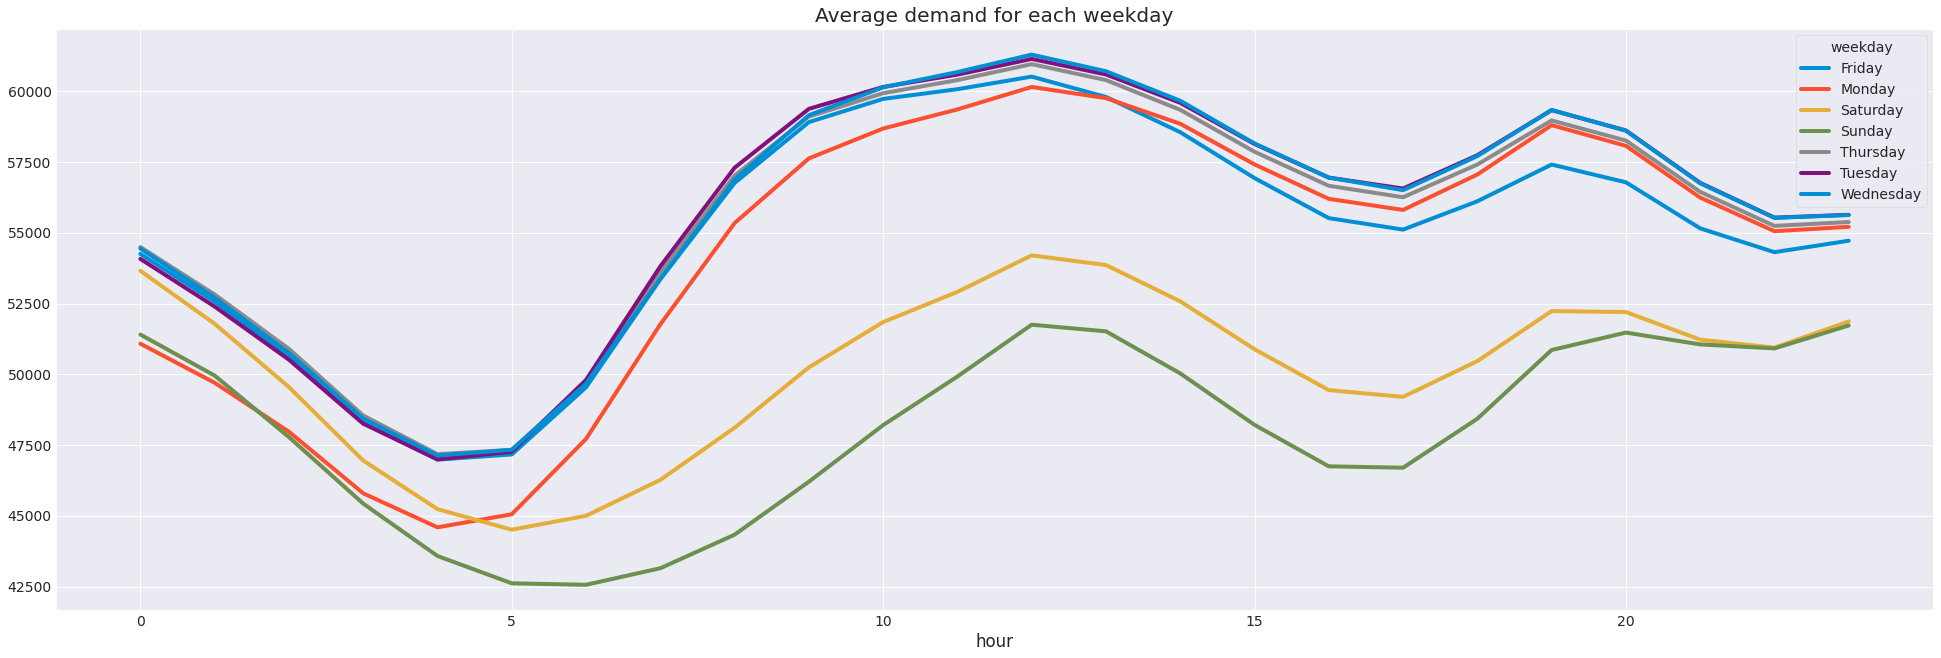

In [ ]:
df.groupby(['hour', 'weekday']).mean()['demand [MW]'].unstack().plot(
    title="Average demand for each weekday", figsize=(30,10)
)

### **Average Demand for each weekday**

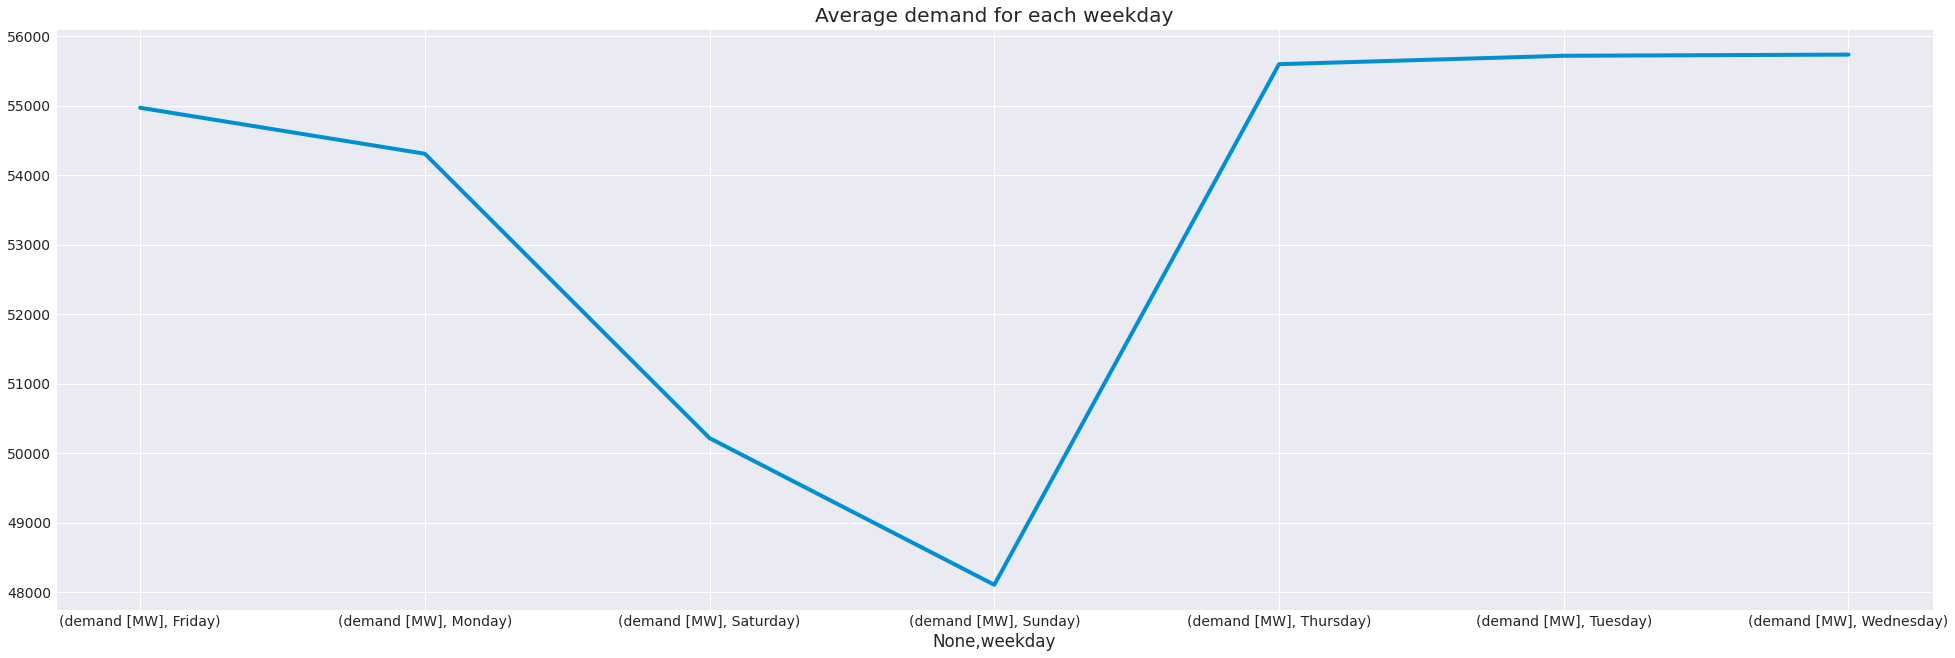

In [ ]:
df[['demand [MW]', 'weekday']].groupby('weekday').mean().unstack().plot(
    title="Average demand for each weekday", figsize=(30,10)
)